# **"PROYECTO DE DATA SCIENCE"** / **"AVANCE PRESENTACIÓN 1"**
* Ignacio Cabrera
* Ignacio Medina
* Felipe Méndez
* Felipe Silva
* Sebastian Espinoza

# <center><h1><b>1. OBTENCION DE DATOS</b></h1></center>


##1.1 Instalacion de dependencias

In [ ]:
!apt-get update -qq
!apt-get install -y -qq chromium-browser chromium-chromedriver

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
^C


In [ ]:
!apt-get update -qq > /dev/null
!apt-get install -y wget unzip > /dev/null
!wget -q https://storage.googleapis.com/chrome-for-testing-public/114.0.5735.90/linux64/chrome-linux64.zip
!wget -q https://storage.googleapis.com/chrome-for-testing-public/114.0.5735.90/linux64/chromedriver-linux64.zip
!unzip -q chrome-linux64.zip
!unzip -q chromedriver-linux64.zip
!mv chrome-linux64 /opt/chrome
!mv chromedriver-linux64/chromedriver /usr/bin/chromedriver
!chmod +x /usr/bin/chromedriver
!pip install -q selenium webdriver-manager


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
unzip:  cannot find or open chromedriver-linux64.zip, chromedriver-linux64.zip.zip or chromedriver-linux64.zip.ZIP.
mv: cannot stat 'chromedriver-linux64/chromedriver': No such file or directory
chmod: cannot access '/usr/bin/chromedriver': No such file or directory


In [ ]:
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
!pip install beautifulsoup4 pandas selenium webdriver_manager

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait

from selenium.webdriver import Chrome
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.chrome.service import Service
import time

import pandas as pd

##1.2 Explicación de los datos a extraer


**Los datos que vamos a extraer de la pagina de Tecnologias en la categoria de Notebook's son los siguientes:**

*   Marca
*   Nombre
*   Precio Descuento
*   Precio Internet
*   Precio Anterior

*A continuación se mostrará de forma grafica lo que se extraera de la pagina antes mencionada.*


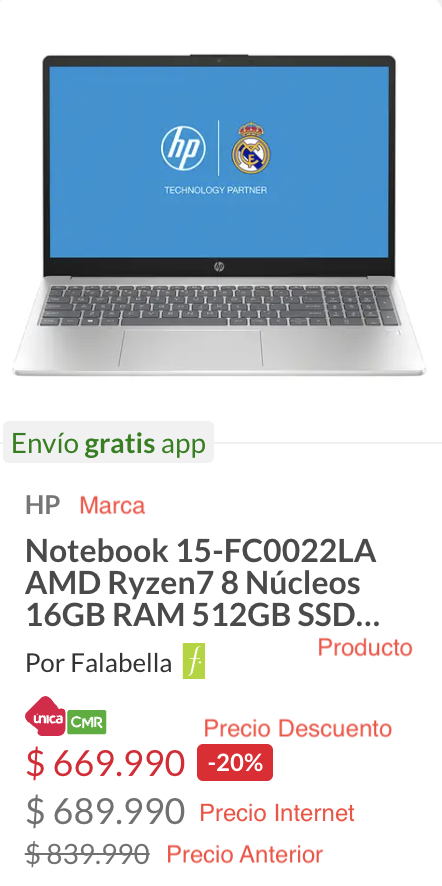

## 1.3 Extracción mediante Web Scraping de los valores mencionado en la categoria Notebook's de Falabella

In [ ]:
# Setup Selenium WebDriver
service = Service(ChromeDriverManager().install())
options = webdriver.ChromeOptions()

options.binary_location = "/opt/chrome/chrome"
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(service=service, options=options)

# URL de la página a scrapear
driver.get("https://www.falabella.com/falabella-cl/category/cat70057/Notebooks")
# Tiempo para que cargue la página
time.sleep(10)

productos_data = []
productos_deseados = 1100 #numero de iteración
productos_capturados = 0
pagina_actual = 1

try:
    while productos_capturados < productos_deseados:
        print(f"Scrapeando la página {pagina_actual}...")

        # Esperar a que los productos se carguen
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.XPATH, "//div[contains(@class, 'search-results-') and contains(@class, 'grid-pod')]"))
        )

        product_containers = driver.find_elements(By.XPATH, "//div[contains(@class, 'search-results-') and contains(@class, 'grid-pod')]")
        print(f"Encontrados {len(product_containers)} productos en la página {pagina_actual}")

        for container in product_containers:
            if productos_capturados >= productos_deseados:
                break
            try:
                nombre_elemento = container.find_element(By.XPATH, ".//b[contains(@class, 'pod-subTitle')]")
                nombre = nombre_elemento.text

                marca_elemento = container.find_element(By.XPATH, ".//b[contains(@class, 'secondary')]")
                marca = marca_elemento.text

                precio_descuento_elemento = container.find_elements(By.XPATH, ".//div[@id[contains(., 'prices-')]]/ol/li[1]/div/span[contains(@class, 'high')]")
                precio_descuento = precio_descuento_elemento[0].text if precio_descuento_elemento else "no encontrado"

                precio_internet_elemento = container.find_elements(By.XPATH, ".//div[@id[contains(., 'prices-')]]/ol/li[2]/div/span[contains(@class, 'medium')]")
                precio_internet = precio_internet_elemento[0].text if precio_internet_elemento else "no encontrado"

                precio_anterior_elemento = container.find_elements(By.XPATH, ".//div[@id[contains(., 'prices-')]]/ol/li[3]/div/span[contains(@class, 'septenary') or contains(@class, 'crossed')]")
                precio_anterior = precio_anterior_elemento[0].text if precio_anterior_elemento else "no encontrado"

                productos_data.append({
                    'Producto': nombre,
                    'Marca': marca,
                    'Precio Descuento': precio_descuento,
                    'Precio Internet': precio_internet,
                    'Precio Anterior': precio_anterior
                })
                productos_capturados += 1
                print(f"Producto {productos_capturados}/{productos_deseados} capturado: {nombre[:30]}...")
            except Exception as e:
                print(f"Error al procesar un producto: {e}")

        if productos_capturados >= productos_deseados:
            break

        pagina_actual += 1

        # Intentamos múltiples formas de hacer clic en el botón de siguiente página
        try:
            print("Intentando hacer clic en el botón de siguiente página...")           # Método 4: JavaScript executor como último recurso
            try:
                driver.execute_script("document.getElementById('testId-pagination-top-arrow-right').click();")
                print("Método 4 (JavaScript) exitoso")
                time.sleep(5)
                continue
            except Exception as e:
                print(f"Método 4 falló: {e}")

            # Si llegamos aquí, no pudimos navegar a la siguiente página
            print("No se pudo navegar a la siguiente página después de varios intentos.")
            break

        except Exception as e:
            print(f"Error general al intentar navegar a la siguiente página: {e}")
            break

except Exception as e:
    print(f"Error general en el script: {e}")

finally:
    # Guardar los resultados incluso si hay errores
    df = pd.DataFrame(productos_data)
    print(f"Total de productos capturados: {len(productos_data)}")
    print(df.head(10).to_string())  # Muestra solo las primeras 10 filas para verificar

    # Guardar los datos en un CSV
    df.to_csv('productos_falabella2.csv', index=False)
    print("Datos guardados en 'productos_marca.csv'")

    # Cerrar el navegador
    driver.quit()

# <center><h1><b>2. PROCESAMIENTO Y LIMPIEZA</b></h1></center>

##2.1 Importar CSV

In [ ]:
import pandas as pd
import numpy as np
import re

try:
    df = pd.read_csv('/content/marcas_falabella.csv')
    print("CSV 'Productos Proyecto Data Science.csv' cargado correctamente.")
    print("Columnas originales:", df.columns.tolist())
except FileNotFoundError:
    print("Error: Archivo 'Productos Proyecto Data Science.csv' no encontrado.")
    exit()
except Exception as e:
    print(f"Error al cargar el CSV: {e}")
    exit()

CSV 'Productos Proyecto Data Science.csv' cargado correctamente.
Columnas originales: ['Producto', 'Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior']


##2.2 Limpieza de Datos y Preparación

In [ ]:
df.replace("no encontrado", np.nan, inplace=True)
df.drop_duplicates(subset=['Producto'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_str = str(price_str).split('-')[0].strip()
    price_str = price_str.replace('$', '').replace('.', '').replace(',', '.').strip()
    try:
        val = float(price_str)
        return val
    except ValueError:
        return np.nan

price_cols = ['Precio Descuento', 'Precio Internet', 'Precio Anterior']
for col in price_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_price)

##2.3 Funciones de Extracción de Características

In [ ]:
def extract_reacondicionado(text):
    if pd.isna(text): return False, text
    text_str = str(text)
    re_match = re.search(r'\b(Reacondicionado|REACONDICIONADO|Seminuevo|REACONDICIONADO GRADO)\b', text_str, re.IGNORECASE)
    if re_match:
        text_modified = text_str.replace(re_match.group(0), "", 1).strip()
        return True, text_modified
    return False, text_str

def extract_ram_corrected(text_input):
    if pd.isna(text_input): return np.nan, text_input
    text = str(text_input)
    ram_val_gb = np.nan

    explicit_ram_patterns = [
        r'(\d+)\s*G[Bb]\s*(?:RAM|DE RAM)\b',
        r'\b(?:RAM DE|RAM)\s*(\d+)\s*G[Bb]\b',
        r'(\d+)RAM\b'
    ]
    for p_text in explicit_ram_patterns:
        match = re.search(p_text, text, re.IGNORECASE)
        if match:

            ram_val_str = None
            if len(match.groups()) == 1:
                 ram_val_str = match.group(1)
            elif len(match.groups()) == 2:
                 ram_val_str = match.group(2) if match.group(2) and match.group(2).isdigit() else match.group(1)

            if ram_val_str and ram_val_str.isdigit():
                ram_val_gb = int(ram_val_str)
                text = text.replace(match.group(0), '', 1).strip()
                return ram_val_gb, text


    match_implicit_ram_storage = re.search(r'\b(\d+)\s*G[Bb]\b(?=\s*(?:SSD|HDD|EMMC)\b)', text, re.IGNORECASE)
    if match_implicit_ram_storage:
        ram_val = int(match_implicit_ram_storage.group(1))
        if ram_val <= 64:

            text = text.replace(match_implicit_ram_storage.group(0), '', 1).strip()
            return ram_val, text


    all_general_gb_matches = []
    for m in re.finditer(r'\b(\d+)\s*G[Bb]\b(?!\s*(?:SSD|HDD|EMMC|VRAM|DE VIDEO|RTX|GTX|Radeon)\b)', text, re.IGNORECASE):
        val = int(m.group(1))

        if val in [4, 6, 8, 12, 16, 24, 32, 48, 64]:
            all_general_gb_matches.append({'val': val, 'match_obj': m, 'pos': m.start()})

    if all_general_gb_matches:
        all_general_gb_matches.sort(key=lambda x: (x['pos'], x['val']))
        best_ram_match = all_general_gb_matches[0]
        ram_val_gb = best_ram_match['val']
        text = text.replace(best_ram_match['match_obj'].group(0), '', 1).strip()
        return ram_val_gb, text

    return np.nan, text_input

def extract_storage_corrected(text_input):
    if pd.isna(text_input): return np.nan, np.nan, text_input
    text = str(text_input)
    storage_type, capacity_gb = np.nan, np.nan
    match_found_and_removed = False

    match_a = re.search(r'(\d+)\s*(GB|TB)\s*(SSD|HDD|EMMC)\b', text, re.IGNORECASE)
    if match_a:
        val = int(match_a.group(1))
        unit = match_a.group(2).upper()
        stype = match_a.group(3).upper()
        capacity_gb = val * 1000 if unit == 'TB' else val
        storage_type = stype
        text = text.replace(match_a.group(0), '', 1).strip()
        match_found_and_removed = True
        return storage_type, capacity_gb, text


    match_b = re.search(r'\b(SSD|HDD|EMMC)\s*(?:DE\s*)?(\d+)\s*(GB|TB)', text, re.IGNORECASE)
    if match_b:
        stype = match_b.group(1).upper()
        val = int(match_b.group(2))
        unit = match_b.group(3).upper()
        capacity_gb = val * 1000 if unit == 'TB' else val
        storage_type = stype
        text = text.replace(match_b.group(0), '', 1).strip()
        match_found_and_removed = True
        return storage_type, capacity_gb, text

    match_c = re.search(r'\b(\d+)\s*(GB|TB)\b(?![\s-]*(?:VRAM|RTX|GTX|Radeon|VIDEO|DE VIDEO|NÚCLEOS|CORE|PRO)\b)', text, re.IGNORECASE)
    if match_c:
        val = int(match_c.group(1))
        unit = match_c.group(2).upper()


        if unit == 'TB' or (unit == 'GB' and val > 64):
            capacity_gb = val * 1000 if unit == 'TB' else val
            storage_type = 'SSD'
            text = text.replace(match_c.group(0), '', 1).strip()
            match_found_and_removed = True
            return storage_type, capacity_gb, text

        elif unit == 'GB' and val <= 64:
             capacity_gb = val
             storage_type = 'EMMC'
             text = text.replace(match_c.group(0), '', 1).strip()
             match_found_and_removed = True
             return storage_type, capacity_gb, text


    if not match_found_and_removed:
        return np.nan, np.nan, text_input

    return storage_type, capacity_gb, text


def extract_graphics_vram(text):
    if pd.isna(text): return np.nan, np.nan, text
    gpu = np.nan
    vram = np.nan
    text_modified = str(text)

    vram_match = re.search(r'(\d+)\s*G[Bb](?:\s*VRAM|\s*vRAM|\s*DE VIDEO|\s*VIDEO)\b', text_modified, re.IGNORECASE)
    if vram_match:
        vram_val_str = vram_match.group(1)
        if vram_val_str:
            vram = int(vram_val_str)
            text_modified = text_modified.replace(vram_match.group(0), "", 1).strip()

    gpu_patterns = [
        r'\b(NVIDIA\s*(?:GeForce\s*)?(?:RTX|GTX|Quadro|MX|T)\s*[A-Z0-9]{3,7}(?:\s*Ti|SUPER|Super|Max-Q|ADA|Ada)?)\b',
        r'\b(AMD\s*(?:Radeon\s*)?(?:RX|Vega|Pro)\s*\w*\s*[A-Z0-9]{3,7}(?:\s*M|XT|GRE)?)\b',
        r'\b(Intel\s*(?:Iris\s*X[eE](?:[\s-]*Graphics)?|UHD(?:\s*Graphics)?|ARC\s*A?\d{3}(?:M)?(?:[\s-]*Graphics)?|Graphics|ARC))\b',
        r'\b(GeForce\s*(?:RTX|GTX|MX)\s*[A-Z0-9]{3,7}(?:[\s-]*Ti|[\s-]*Super|[\s-]*Max-Q)?)\b',
        r'\b(Radeon\s*(?:RX|Vega|Pro)\s*\w*\s*[A-Z0-9]{3,7}(?:[\s-]*M)?)\b',
        r'\b(RTX\s*\d{4}(?:\s*Ti|SUPER|Super)?)\b',
        r'\b(GTX\s*\d{4}(?:\s*Ti|SUPER|Super)?)\b',
        r'\b(MX\d{3})\b'
    ]
    for pattern in gpu_patterns:
        gpu_match = re.search(pattern, text_modified, re.IGNORECASE)
        if gpu_match:
            gpu = gpu_match.group(0).strip()
            text_modified = text_modified.replace(gpu_match.group(0), "", 1).strip()
            break

    return gpu, vram, text_modified

def extract_screen_size(text):
    if pd.isna(text): return np.nan, text
    text_str = str(text)

    match_specific = re.search(r'(\d{1,2}(?:[,.]\d{1,2})?)\s*(?:\"|\'\'|”| pulgadas|pulgada|-pulgadas|pulg\.?)\b', text_str, re.IGNORECASE)
    if match_specific:
        size_str = match_specific.group(1).replace(',', '.')
        screen_size = float(size_str)
        text_modified = text_str.replace(match_specific.group(0), "", 1).strip()
        return screen_size, text_modified


    match_decimal_no_unit = re.search(r'\b(\d{1,2}[,.]\d)\b(?![\s-]*(?:HZ|K\b|GB|TB|VRAM|RAM|SSD|HDD|CORE|NÚCLEOS|GHZ)\b)', text_str, re.IGNORECASE)
    if match_decimal_no_unit:
        size_str = match_decimal_no_unit.group(1).replace(',', '.')
        screen_size = float(size_str)
        text_modified = text_str.replace(match_decimal_no_unit.group(0), "", 1).strip()
        return screen_size, text_modified


    match_int_no_unit = re.search(r'\b(1[3-7])(?![\d,.])\b(?![\s-]*(?:HZ|K\b|GB|TB|VRAM|RAM|SSD|HDD|CORE|NÚCLEOS|GHZ)\b)', text_str, re.IGNORECASE)
    if match_int_no_unit:
        screen_size = float(match_int_no_unit.group(1))
        text_modified = text_str.replace(match_int_no_unit.group(0), "", 1).strip()
        return screen_size, text_modified

    return np.nan, text_str

def extract_processor(text):
    if pd.isna(text): return np.nan, text
    text_str = str(text)

    processor_patterns = [
        (r'\b(Intel\s*Core\s*Ultra\s*[579](?:[\s-]*\d{3,4}[HUPhhx]{1,2})?)\b', "", False),
        (r'\b(Intel\s*Core\s*[imx]\d(?:[\s-]*\d{3,5}[A-Z0-9]{0,4}[GHYUPhhxXx]?))\b', "", False),
        (r'\b(Intel\s*Core\s*[imx]\d)\b', "", False),
        (r'\b(Intel\s*(?:Celeron|Pentium|N\d{3,4})(?:[\s-]*Gold|[\s-]*[N]?\d{3,4}[A-Z]?)?)\b', "", False),
        (r'\b(AMD\s*Ryzen\s*(?:AI\s*)?[R]?[3579](?:[\s-]*PRO)?(?:[\s-]*\d{3,4}[A-Z]{1,3}[XxHSUZe]?))\b', "", False),
        (r'\b(AMD\s*Ryzen\s*(?:AI\s*)?[R]?[3579](?:[\s-]*PRO)?)\b', "", False),
        (r'\b(Apple\s*)?(?:Chip\s*)?(M\d(?:[\s-]*Pro|[\s-]*Max|[\s-]*Ultra)?)\b', "Apple ", True),
        (r'\b(Snapdragon(?:[\s-]*X\s*Elite)?)\b', "", False),
        (r'\b(Qualcomm)\b', "", False),

        (r'\b([imx]\d(?:[\s-]*\d{3,5}[A-Z0-9]{0,4}[GHYUPhhxXx]?))\b', "Intel Core ", True),
        (r'\b(Core\s*[imx]\d)\b', "Intel ", True),
        (r'\b([imx]\d)\b', "Intel Core ", True),
        (r'\b(Ryzen\s*[R]?[3579](?:[\s-]*PRO)?(?:[\s-]*\d{3,4}[A-Z]{1,3}[XxHSUZe]?))\b', "AMD ", True),
        (r'\b(Ryzen™?\s*[R]?[3579](?:[\s-]*PRO)?)\b', "AMD ", True)
    ]
    text_clean = text_str.replace('™', '').replace('®', '')
    for pattern, prefix, _ in processor_patterns:
        match = re.search(pattern, text_clean, re.IGNORECASE)
        if match:

            processor_name_core = match.group(1) if len(match.groups()) > 0 and match.group(1) else match.group(0)
            processor_name = processor_name_core.strip()

            if prefix:
                if not re.search(r'\b' + re.escape(prefix.strip()) + r'\b', processor_name, re.IGNORECASE):
                    processor_name = prefix.strip() + " " + processor_name


            if "Apple" in processor_name or processor_name.startswith("M"):
                 m_match = re.search(r'(M\d(?:[\s-]*Pro|[\s-]*Max|[\s-]*Ultra)?)', processor_name, re.IGNORECASE)
                 if m_match:
                    processor_name = "Apple " + m_match.group(1).replace(" ","").upper()


            text_modified = text_str.replace(match.group(0), "", 1).strip()
            return processor_name, text_modified

    return np.nan, text_str

df['Producto_Limpio_Iter'] = df['Producto'].astype(str)

new_cols = ['Marca', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB',
            'Tarjeta_Grafica', 'VRAM_GB', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado']
for col in new_cols:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).replace(["no encontrado", "", "nan"], np.nan)

numeric_feature_cols = ['RAM_GB', 'VRAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']
for col in numeric_feature_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Marca (solo estandarizar si ya existe, no extraer del texto)
if 'Marca' in df.columns:
    df['Marca'] = df['Marca'].astype(str).str.strip().str.upper().replace(['NAN', 'nan'], np.nan, regex=False)
    print("Columna 'Marca' estandarizada.")
else:
    df['Marca'] = np.nan # Crear columna vacía si no existe
    print("Columna 'Marca' no encontrada, creada como NaN.")


# 2. Reacondicionado (No change needed here based on the problem description)
reac_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_reacondicionado(x), index=['val', 'text']))
df['Es_Reacondicionado'] = df['Es_Reacondicionado'].fillna(reac_results['val']).fillna(False).astype(bool)
df['Producto_Limpio_Iter'] = reac_results['text']

# 3. Gráficos y VRAM (No change needed here based on the problem description)
gpu_vram_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_graphics_vram(x), index=['gpu', 'vram', 'text']))
df['Tarjeta_Grafica'] = df['Tarjeta_Grafica'].fillna(gpu_vram_results['gpu'])
# df['VRAM_GB'] column is later deleted, so its fillna might not be critical here if it's always deleted
df['VRAM_GB'] = df['VRAM_GB'].fillna(gpu_vram_results['vram'])
df['Producto_Limpio_Iter'] = gpu_vram_results['text']

# 4. RAM - USE THE CORRECTED FUNCTION
# Rename extract_ram_corrected to extract_ram or call the new name
ram_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_ram_corrected(x), index=['val', 'text']))
df['RAM_GB'] = df['RAM_GB'].fillna(ram_results['val'])
df['Producto_Limpio_Iter'] = ram_results['text']

# 5. Almacenamiento - USE THE CORRECTED FUNCTION
# Rename extract_storage_corrected to extract_storage or call the new name
storage_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_storage_corrected(x), index=['type', 'cap', 'text']))
df['Tipo_Almacenamiento'] = df['Tipo_Almacenamiento'].fillna(storage_results['type'])
df['Capacidad_Almacenamiento_GB'] = df['Capacidad_Almacenamiento_GB'].fillna(storage_results['cap'])
df['Producto_Limpio_Iter'] = storage_results['text']

# 6. Procesador (No change needed here based on the problem description)
proc_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_processor(x), index=['val', 'text']))
df['Procesador'] = df['Procesador'].fillna(proc_results['val'])
df['Producto_Limpio_Iter'] = proc_results['text']

# 7. Pantalla (No change needed here based on the problem description)
screen_results = df['Producto_Limpio_Iter'].apply(lambda x: pd.Series(extract_screen_size(x), index=['val', 'text']))
df['Pantalla_Pulgadas'] = df['Pantalla_Pulgadas'].fillna(screen_results['val'])
df['Producto_Limpio_Iter'] = screen_results['text']

def final_clean_producto(text):
    if pd.isna(text): return text
    text = str(text)
    common_specs = [
        r'\b(?:FHD|WUXGA|OLED|IPS|LCD|LED)\b', r'\b(?:Wi-Fi\s*\d?|Webcam\s*\d*p?)\b',
        r'\b(?:Táctil|Touch|Lápiz|Mochila|Bolso Regalo)\b', r'\b(?:NVIDIA G-Sync|G-Sync|FreeSync)\b',
        r'\b(?:Retroiluminado|Teclado Retroiluminado)\b', r'\b(?:DDR\d)\b',
        r'\b(?:[Nn]ucl[eé]os?|[Cc]ores?)\b', r'\b(?:gen|Gen\.)\b', r'\b(?:W10|W11|Windows)\b',
        r'\b(?:Pro|Home|Edition|Español)\b',
        r'\b(?:Color\s*\w+|Gris\s*\w*|Plata|Azul|Negro|Blanco)\b',
        r'\b(?:Hz)\b', r'\b(?:SSD|HDD|RAM)\b'
    ]
    # Eliminar la marca del texto limpio si la columna Marca tiene un valor
    # Esto se hace aquí para no afectar las extracciones previas.


    for spec_pattern in common_specs:
        text = re.sub(spec_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(r'[\s/,-]+', ' ', text)
    text = re.sub(r'\s*-\s*', ' ', text)
    text = re.sub(r'\(\s*\)', '', text)
    text = re.sub(r'\s{2,}', ' ', text).strip(' ,-/"\'')
    return text

# Guardar la columna 'Producto' original
if 'Producto_Original' not in df.columns: # Evitar sobreescribir si se corre múltiples veces
    df['Producto_Original'] = df['Producto']

df['Producto_Limpio'] = df['Producto_Limpio_Iter'].astype(str).apply(final_clean_producto)

df.rename(columns={'Producto': 'Temp_Original_Producto_Name_Holder', 'Producto_Limpio': 'Producto'}, inplace=True)
if 'Temp_Original_Producto_Name_Holder' in df.columns:
    del df['Temp_Original_Producto_Name_Holder']
if 'Producto_Limpio_Iter' in df.columns:
    del df['Producto_Limpio_Iter']

Columna 'Marca' estandarizada.


/tmp/ipython-input-283-3296301350.py:248: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Es_Reacondicionado'] = df['Es_Reacondicionado'].fillna(reac_results['val']).fillna(False).astype(bool)


##2.4 Mostrar los Resultados



In [ ]:
print("\n--- Características Extraídas y Producto Limpio (Primeras Filas) ---")
selected_cols_display = [
    'Producto', 'Marca', 'Procesador', 'RAM_GB',
    'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB',
    'Tarjeta_Grafica', 'VRAM_GB', 'Pantalla_Pulgadas',
    'Es_Reacondicionado'
]
# Solo mostrar columnas que existen, para evitar KeyError si alguna no se creó
existing_selected_cols = [col for col in selected_cols_display if col in df.columns]

for col in ['RAM_GB', 'VRAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

if not df.empty:
    print(df[existing_selected_cols].head(20).to_string())
    print("\n--- Resumen de Nulos por Característica Extraída ---")
    print(df[existing_selected_cols].isnull().sum())
    print("\n--- Tipos de Datos del DataFrame Final ---")
    print(df.dtypes)
    df.to_csv('Productos_Falabella_Procesado_1.csv', index=False, encoding='utf-8-sig')
    print("\nDataFrame procesado y final guardado en 'Productos_Falabella_Procesado_1.csv'")
    print("\n--- Información del DataFrame Final ---")
    df.info()
else:
    print("DataFrame está vacío después de la carga o la limpieza inicial.")


--- Características Extraídas y Producto Limpio (Primeras Filas) ---
                                         Producto    Marca             Procesador  RAM_GB Tipo_Almacenamiento  Capacidad_Almacenamiento_GB          Tarjeta_Grafica  VRAM_GB  Pantalla_Pulgadas  Es_Reacondicionado
0                  Notebook 15 FC0022LA 8 Núcleos       HP             AMD Ryzen7    16.0                 SSD                        512.0                      NaN      NaN               15.6               False
1   Notebook Gamer Victus 15 FB1007LA 4GB " 144Hz       HP     AMD Ryzen 5 7535HS     8.0                 SSD                        512.0                 RTX 2050      NaN               15.6               False
2                 Notebook Ideapad Slim 5 " 16:10   LENOVO   Intel Core i5-12450H     8.0                 SSD                        512.0                      NaN      NaN               14.0               False
3                         Notebook Ideapad Slim 3   LENOVO            AMD Ryzen 7 

In [ ]:
# --- 2.4 INGENIERÍA DE CARACTERÍSTICAS ADICIONAL PARA PROCESADORES ---
# El objetivo es crear variables más específicas para el procesador, lo que
# probablemente aumentará su importancia en el modelo.

print("\n--- Creando características de Procesador más detalladas ---")

# Asegurarnos de que la columna 'Procesador' existe y es de tipo string para poder manipularla.
if 'Procesador' in df.columns:
    # Creamos una columna temporal en minúsculas para facilitar la búsqueda de texto.
    df['Procesador_str'] = df['Procesador'].astype(str).str.lower()

    # 1. Extraer Marca del Procesador (Intel, AMD, Apple)
    # Esta es una característica de alto nivel muy importante.
    def get_proc_marca(text):
        if 'intel' in text or 'celeron' in text or 'pentium' in text:
            return 'Intel'
        if 'amd' in text or 'ryzen' in text or 'athlon' in text:
            return 'AMD'
        if 'apple' in text or 'm1' in text or 'm2' in text or 'm3' in text or 'm4' in text:
            return 'Apple'
        if 'snapdragon' in text or 'qualcomm' in text:
            return 'Qualcomm'
        return 'Desconocido'

    df['Procesador_Marca'] = df['Procesador_str'].apply(get_proc_marca)

    # 2. Extraer Serie del Procesador (Core i5, Ryzen 7, etc.)
    # Esta característica es más granular y mucho más predictiva que el 'Procesador_Grupo' anterior.
    def get_proc_serie(text):
        if 'core ultra 9' in text: return 'Core Ultra 9'
        if 'core ultra 7' in text: return 'Core Ultra 7'
        if 'core ultra 5' in text: return 'Core Ultra 5'
        if 'core i9' in text: return 'Core i9'
        if 'core i7' in text: return 'Core i7'
        if 'core i5' in text: return 'Core i5'
        if 'core i3' in text: return 'Core i3'
        if 'ryzen 9' in text: return 'Ryzen 9'
        if 'ryzen 7' in text: return 'Ryzen 7'
        if 'ryzen 5' in text: return 'Ryzen 5'
        if 'ryzen 3' in text: return 'Ryzen 3'
        if 'm4' in text: return 'Apple M4'
        if 'm3' in text: return 'Apple M3'
        if 'm2' in text: return 'Apple M2'
        if 'm1' in text: return 'Apple M1'
        if 'pentium' in text: return 'Pentium'
        if 'celeron' in text: return 'Celeron'
        if 'snapdragon' in text: return 'Snapdragon'
        return 'Otro/Desconocido'

    df['Procesador_Serie'] = df['Procesador_str'].apply(get_proc_serie)

    # 3. Agrupar las series menos comunes para reducir el ruido
    serie_counts = df['Procesador_Serie'].value_counts()
    threshold_serie = 10  # Agrupamos si hay menos de 10 notebooks con esa serie
    series_raras = serie_counts[serie_counts < threshold_serie].index
    df['Procesador_Serie'] = df['Procesador_Serie'].replace(series_raras, 'Otro/Desconocido')

    print("\nDistribución de la nueva característica 'Procesador_Marca':")
    print(df['Procesador_Marca'].value_counts())

    print("\nDistribución de la nueva característica 'Procesador_Serie' (agrupada):")
    print(df['Procesador_Serie'].value_counts())

    # Eliminar la columna temporal que ya no necesitamos
    df.drop('Procesador_str', axis=1, inplace=True)

    # También eliminamos la columna 'Procesador_Grupo' anterior para no usarla en el modelo
    if 'Procesador_Grupo' in df.columns:
        df.drop('Procesador_Grupo', axis=1, inplace=True)
        print("\nColumna 'Procesador_Grupo' original eliminada.")

else:
    print("La columna 'Procesador' no se encontró. No se crearon nuevas características.")


--- Creando características de Procesador más detalladas ---

Distribución de la nueva característica 'Procesador_Marca':
Procesador_Marca
Intel          493
Desconocido    110
AMD            103
Apple           26
Qualcomm         2
Name: count, dtype: int64

Distribución de la nueva característica 'Procesador_Serie' (agrupada):
Procesador_Serie
Core i5             245
Otro/Desconocido    168
Core i7             144
Ryzen 7              50
Core i9              32
Core i3              30
Ryzen 5              26
Core Ultra 7         17
Ryzen 3              12
Celeron              10
Name: count, dtype: int64


##2.5 Eliminación de dispositivos que NO son Notebooks

In [ ]:
df_cleaned = df.copy()

# Convertir columnas a string y luego a minúsculas para búsqueda insensible a mayúsculas
# Rellenar NaN con string vacío para evitar errores con .str.contains()
df_cleaned['Producto_Lower'] = df_cleaned['Producto'].astype(str).str.lower()
df_cleaned['Producto_Original_Lower'] = df_cleaned['Producto_Original'].astype(str).str.lower()
df_cleaned['Marca_Lower'] = df_cleaned['Marca'].astype(str).str.lower()

# Keywords para identificar productos que NO son notebooks
non_notebook_keywords = [
    'monitor', 'soporte', 'teclado', 'estuche', 'fuente de poder', 'plotter',
    'cinch', 'hervidor', 'insumos', 'herramientas', 'cable', 'adaptador',
    'mouse', 'funda',  # A veces vienen con notebooks
    'estampadora', 'hoby press', 'impresora', 'multifuncional',
    'enfriador', 'ventilación para notebook', # Accesorios
    'para notebook', # Frase genérica para accesorios
    'power atx', 'watt w/', # Fuentes de poder
    'electrico', # Para el hervidor
    'pen ', # Lápices digitales como producto principal
    'teclado usb', 'pad numerico',
    'disco solido', # Si es SOLO el disco
    'ram', # Si es SOLO la RAM
    'aio ', 'all-in-one', 'eliteone', # Desktops All-in-One
    'mac mini', 'imac', # Desktops de Apple
    'pc', # A veces usado para desktops, pero puede ser ambiguo
    'desktop', 'escritorio',
    'tablet', # Tableta pura, no convertible. 'surface laptop' es notebook.
              # 'galaxy book 360' es notebook. 'tablet y laptop' es notebook.
              # Esta es delicada, se refinará.
    'celular', 'smartphone',
    'audifonos', 'headset',
    'mochila', # Si es el producto principal
    'bolso', # Si es el producto principal
    'docking', 'dock',
    'cargador', # Si es el producto principal
    'bateria', # Si es el producto principal
    'pantalla', # Si es solo la pantalla y no parte de un notebook
    'webcam', # Si es solo la webcam
    'limpiador', 'kit de limpieza'
]

# Usaremos esto con precaución o combinado con keywords.
suspicious_brands = [
    'silhouette', 'xtech', 'linkon', 'startechoffice', 'xiaomi' # Xiaomi vende notebooks, pero el hervidor es un claro no-notebook
]

# Máscara inicial: todos son notebooks (True)
is_notebook_mask = pd.Series([True] * len(df_cleaned), index=df_cleaned.index)

# Aplicar filtro por keywords
for keyword in non_notebook_keywords:
    # Si la keyword está en Producto O Producto_Original, marcar como NO notebook (False)
    condition = (df_cleaned['Producto_Lower'].str.contains(keyword, na=False)) | \
                (df_cleaned['Producto_Original_Lower'].str.contains(keyword, na=False))

    # Excepciones: no eliminar si dice "notebook" o "laptop" explícitamente
    # Esto es para evitar eliminar "soporte para notebook" si la keyword es "para notebook"
    # o "tablet y laptop" si la keyword es "tablet".
    # Si el keyword es muy específico (e.g. 'hervidor'), no necesita esta excepción.
    if keyword in ['para notebook', 'tablet', 'pantalla', 'disco solido', 'ram', 'mouse', 'funda', 'mochila', 'bolso', 'cargador', 'bateria', 'webcam', 'pen ']:
        is_notebook_mask &= ~(condition &
                              ~df_cleaned['Producto_Lower'].str.contains('notebook|laptop|portatil|macbook|book|gamer|ultrabook|chromebook|netbook', na=False) &
                              ~df_cleaned['Producto_Original_Lower'].str.contains('notebook|laptop|portatil|macbook|book|gamer|ultrabook|chromebook|netbook', na=False)
                             )
    else:
        is_notebook_mask &= ~condition


# Filtro específico para iMac y Mac Mini (más robusto)
is_notebook_mask &= ~(df_cleaned['Producto_Original_Lower'].str.contains('imac\(', na=False))
is_notebook_mask &= ~(df_cleaned['Producto_Lower'].str.contains('imac', na=False) & ~df_cleaned['Producto_Lower'].str.contains('notebook|laptop', na=False))
is_notebook_mask &= ~(df_cleaned['Producto_Original_Lower'].str.contains('mac mini', na=False))
is_notebook_mask &= ~(df_cleaned['Producto_Lower'].str.contains('mac mini', na=False))

# Filtro para AIOs que no se llamen explícitamente notebook/laptop
is_notebook_mask &= ~(
    (df_cleaned['Producto_Lower'].str.contains('aio |all-in-one|eliteone', na=False) | \
     df_cleaned['Producto_Original_Lower'].str.contains('aio |all-in-one|eliteone', na=False)) & \
    ~df_cleaned['Producto_Lower'].str.contains('notebook|laptop', na=False) & \
    ~df_cleaned['Producto_Original_Lower'].str.contains('notebook|laptop', na=False)
)

# Filtro por marcas sospechosas (si venden casi exclusivamente no-notebooks)
# Por ejemplo, Silhouette con sus plotters.
# Si una marca está en suspicious_brands Y el producto no tiene "notebook" o "laptop", se elimina.
for brand_keyword in suspicious_brands:
    condition_brand = df_cleaned['Marca_Lower'] == brand_keyword
    # Solo eliminar si además no parece un notebook por su nombre
    condition_name_not_notebook = ~df_cleaned['Producto_Lower'].str.contains('notebook|laptop|portatil|macbook|book|gamer', na=False) & \
                                  ~df_cleaned['Producto_Original_Lower'].str.contains('notebook|laptop|portatil|macbook|book|gamer', na=False)
    is_notebook_mask &= ~(condition_brand & condition_name_not_notebook)


# Aplicar la máscara para obtener los notebooks
df_final_notebooks = df_cleaned[is_notebook_mask].copy()

# Guardar los que se identificaron como no notebooks para revisión
df_non_notebooks = df_cleaned[~is_notebook_mask].copy()

# Eliminar columnas auxiliares
df_final_notebooks.drop(columns=['Producto_Lower', 'Producto_Original_Lower', 'Marca_Lower'], inplace=True)
df_non_notebooks.drop(columns=['Producto_Lower', 'Producto_Original_Lower', 'Marca_Lower'], inplace=True)


print(f"\nNúmero de filas después de la limpieza: {len(df_final_notebooks)}")
print(f"Número de filas eliminadas (identificadas como no-notebooks): {len(df_non_notebooks)}")

print("\n--- Muestra de productos eliminados (revisar si hay falsos positivos) ---")
if not df_non_notebooks.empty:
    print(df_non_notebooks[['Marca', 'Producto_Original', 'Producto']].head(30))
else:
    print("No se eliminaron productos con los criterios actuales.")

print("\n--- Muestra de productos conservados (revisar si hay falsos negativos) ---")
if not df_final_notebooks.empty:
    print(df_final_notebooks[['Marca', 'Producto_Original', 'Producto']].sample(min(10, len(df_final_notebooks))))
else:
    print("Todos los productos fueron eliminados con los criterios actuales.")

# descargar el nuevo archivo limpio:
df_final_notebooks.to_csv('Productos-Notebooks-Limpios.csv', index=False)


Número de filas después de la limpieza: 658
Número de filas eliminadas (identificadas como no-notebooks): 76

--- Muestra de productos eliminados (revisar si hay falsos positivos) ---
               Marca                                  Producto_Original  \
45             APPLE                         Mac Mini M4 10C 16GB 256GB   
97   HEWLETT PACKARD  HP Intel core i7 con 16GB de Ram disco SSD y p...   
98             APPLE  IMac (24", M4 (10n CPU, 10n GPU), 16GB RAM, 25...   
116               HP  EliteOne 800 G4, Intel Core i7-8700, 23.8", 8G...   
128             DELL  Latitude 5420 32GB RAM 512GB SSD (Reacondidion...   
132               HP  Dragonfly Pro AMD Ryzen 7-7736U 8-Core 16GB LP...   
137             DELL  XPS 9350 13.3" i5-7200U 256SSD 8gbram fullHD O...   
144           LENOVO       THINKPAD L580 , SSD DE 512 GB , 16 GB EN RAM   
160       SILHOUETTE                      Portrait 3 + cinch Verde S112   
184             DELL          INSPIRON 3530 Intel i7, 16GB Ram, 1

## 2.6 Eliminación fila VRAM

In [ ]:
# Cargar el CSV generado
try:
    df_limpio = pd.read_csv('Productos-Notebooks-Limpios.csv')
    print("\nCSV 'Productos-Notebooks-Limpios.csv' cargado correctamente para eliminación de VRAM.")
    print("Columnas antes de eliminar 'VRAM_GB':", df_limpio.columns.tolist())
except FileNotFoundError:
    print("\nError: Archivo 'Productos-Notebooks-Limpios.csv' no encontrado.")
    exit()
except Exception as e:
    print(f"\nError al cargar el CSV 'Productos-Notebooks-Limpios.csv': {e}")
    exit()

# Eliminar la columna 'VRAM_GB' si existe
if 'VRAM_GB' in df_limpio.columns:
    df_limpio.drop(columns=['VRAM_GB'], inplace=True)
    print("\nColumna 'VRAM_GB' eliminada.")
else:
    print("\nLa columna 'VRAM_GB' no existe en el DataFrame.")

# Mostrar las columnas después de la eliminación
print("Columnas después de eliminar 'VRAM_GB':", df_limpio.columns.tolist())

# Guardar el DataFrame modificado de nuevo en un archivo CSV
df_limpio.to_csv('Productos-NO-VRAM.csv', index=False)
print("\nDataFrame modificado guardado en 'Productos-Notebooks-Limpios.csv'")

# Mostrar información del DataFrame final
print("\n--- Información del DataFrame Final Después de Eliminar VRAM ---")
df_limpio.info()

# Mostrar una muestra del DataFrame final
print("\n--- Muestra del DataFrame Final Después de Eliminar VRAM (Primeras Filas) ---")
print(df_limpio.head().to_string())



CSV 'Productos-Notebooks-Limpios.csv' cargado correctamente para eliminación de VRAM.
Columnas antes de eliminar 'VRAM_GB': ['Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB', 'Tarjeta_Grafica', 'VRAM_GB', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado', 'Producto_Original', 'Producto', 'Procesador_Marca', 'Procesador_Serie']

Columna 'VRAM_GB' eliminada.
Columnas después de eliminar 'VRAM_GB': ['Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB', 'Tarjeta_Grafica', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado', 'Producto_Original', 'Producto', 'Procesador_Marca', 'Procesador_Serie']

DataFrame modificado guardado en 'Productos-Notebooks-Limpios.csv'

--- Información del DataFrame Final Después de Eliminar VRAM ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 15 col

## 2.7 Eliminar fila Producto_Original

In [ ]:
# Cargar el CSV generado
try:
    df_no_vram = pd.read_csv('Productos-NO-VRAM.csv')
    print("\nCSV 'Productos-NO-VRAM.csv' cargado correctamente para eliminación de Producto_Original.")
    print("Columnas antes de eliminar 'Producto_Original':", df_no_vram.columns.tolist())
except FileNotFoundError:
    print("\nError: Archivo 'Productos-NO-VRAM.csv' no encontrado.")
    exit()
except Exception as e:
    print(f"\nError al cargar el CSV 'Productos-NO-VRAM.csv': {e}")
    exit()

# Eliminar la columna 'Producto_Original' si existe
if 'Producto_Original' in df_no_vram.columns:
    df_no_vram.drop(columns=['Producto_Original'], inplace=True)
    print("\nColumna 'Producto_Original' eliminada.")
else:
    print("\nLa columna 'Producto_Original' no existe en el DataFrame.")

# Mostrar las columnas después de la eliminación
print("Columnas después de eliminar 'Producto_Original':", df_no_vram.columns.tolist())

# Guardar el DataFrame modificado de nuevo en un archivo CSV
df_no_vram.to_csv('Productos-NO-PO.csv', index=False)
print("\nDataFrame modificado guardado en 'Productos-NO-PO.csv'")

# Mostrar información del DataFrame final
print("\n--- Información del DataFrame Final Después de Eliminar Producto_Original ---")
df_no_vram.info()

# Mostrar una muestra del DataFrame final
print("\n--- Muestra del DataFrame Final Después de Eliminar Producto_Original (Primeras Filas) ---")
print(df_no_vram.head().to_string())


CSV 'Productos-NO-VRAM.csv' cargado correctamente para eliminación de Producto_Original.
Columnas antes de eliminar 'Producto_Original': ['Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB', 'Tarjeta_Grafica', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado', 'Producto_Original', 'Producto', 'Procesador_Marca', 'Procesador_Serie']

Columna 'Producto_Original' eliminada.
Columnas después de eliminar 'Producto_Original': ['Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB', 'Tarjeta_Grafica', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado', 'Producto', 'Procesador_Marca', 'Procesador_Serie']

DataFrame modificado guardado en 'Productos-NO-PO.csv'

--- Información del DataFrame Final Después de Eliminar Producto_Original ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 14 c

## 2.8 Agregar en la columna Tarjeta_Grafica valores "No posee" a los espacios vacios

In [ ]:
# Cargar el CSV generado
try:
    # Load the CSV file into the df_no_po DataFrame
    df_no_po = pd.read_csv('Productos-NO-PO.csv')
    print("\nCSV 'Productos-NO-PO.csv' cargado correctamente para rellenar Tarjeta_Grafica.")
    print("Columnas antes de rellenar 'Tarjeta_Grafica':", df_no_po.columns.tolist())
except FileNotFoundError:
    print("\nError: Archivo 'Productos-NO-PO.csv' no encontrado.")
    exit()
except Exception as e:
    print(f"\nError al cargar el CSV 'Productos-NO-PO.csv': {e}")
    exit()


# Rellenar valores nulos en la columna 'Tarjeta_Grafica' con "No posee"
if 'Tarjeta_Grafica' in df_no_po.columns:
    df_no_po['Tarjeta_Grafica'].fillna('No posee', inplace=True)
    print("\nValores vacíos en la columna 'Tarjeta_Grafica' rellenados con 'No posee'.")
else:
    print("\nLa columna 'Tarjeta_Grafica' no existe en el DataFrame.")

# Guardar el DataFrame modificado
df_no_po.to_csv('Productos-check-1.csv', index=False)
print("\nDataFrame modificado guardado en 'Productos-check-1.csv'")

# Mostrar información del DataFrame después del cambio
print("\n--- Información del DataFrame Después de Rellenar Tarjeta_Grafica ---")
df_no_po.info()

# Mostrar una muestra de la columna modificada
print("\n--- Muestra de la columna 'Tarjeta_Grafica' después de rellenar ---")
print(df_no_po[['Producto', 'Tarjeta_Grafica']].head().to_string())


CSV 'Productos-NO-PO.csv' cargado correctamente para rellenar Tarjeta_Grafica.
Columnas antes de rellenar 'Tarjeta_Grafica': ['Marca', 'Precio Descuento', 'Precio Internet', 'Precio Anterior', 'RAM_GB', 'Tipo_Almacenamiento', 'Capacidad_Almacenamiento_GB', 'Tarjeta_Grafica', 'Pantalla_Pulgadas', 'Procesador', 'Es_Reacondicionado', 'Producto', 'Procesador_Marca', 'Procesador_Serie']

Valores vacíos en la columna 'Tarjeta_Grafica' rellenados con 'No posee'.

DataFrame modificado guardado en 'Productos-check-1.csv'

--- Información del DataFrame Después de Rellenar Tarjeta_Grafica ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Marca                        658 non-null    object 
 1   Precio Descuento             138 non-null    float64
 2   Precio Internet              581 non-null    float64
 3   Precio Ant

/tmp/ipython-input-289-1576104441.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_no_po['Tarjeta_Grafica'].fillna('No posee', inplace=True)


In [ ]:

try:
    df_no_po = pd.read_csv('Productos-check-1.csv')

    if 'Marca' in df_no_po.columns:
        # Get the number of unique values in the 'Marca' column
        num_unique_marcas = df_no_po['Marca'].nunique()
        print(f"\nEl número de marcas únicas en el CSV es: {num_unique_marcas}")

    else:
        print("\nError: La columna 'Marca' no se encuentra en el DataFrame.")

except FileNotFoundError:
    print("\nError: Archivo 'Productos-check-1.csv' no encontrado.")
except Exception as e:
    print(f"\nError al procesar el DataFrame: {e}")




El número de marcas únicas en el CSV es: 20


# <center><h1><b>3. ANALISIS EXPLORATORIO</b></h1></center>

## 3.1 CONFIGURACIÓN INICAL, CARGA Y COMPRENSIÓN INICIAL DE DATOS



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, chi2_contingency, kruskal
from scipy import stats as sc_stats # Para probplot
from sklearn.preprocessing import LabelEncoder

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
%matplotlib inline
pd.options.mode.chained_assignment = None

# --- FASE 1: CARGA Y COMPRENSIÓN INICIAL DE DATOS ---
print("--- 1. CARGA Y COMPRENSIÓN INICIAL ---")
try:
    df = pd.read_csv('Productos-check-1.csv')
    print("CSV 'Productos-check-1.csv' cargado correctamente.")
except FileNotFoundError:
    print("Error: Archivo 'Productos-check-1.csv' no encontrado.")
    exit()

if 'Producto' in df.columns:
    df['Nombre_Original_Producto'] = df['Producto']
else:
    df['Nombre_Original_Producto'] = "Nombre Desconocido"

print(f"\nFilas duplicadas (Nombre_Original_Producto): {df.duplicated(subset=['Nombre_Original_Producto']).sum()} ---")
if df.duplicated(subset=['Nombre_Original_Producto']).sum() > 0:
    df.drop_duplicates(subset=['Nombre_Original_Producto'], keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"Dimensiones después de eliminar duplicados: {df.shape}")


--- 1. CARGA Y COMPRENSIÓN INICIAL ---
CSV 'Productos-check-1.csv' cargado correctamente.

Filas duplicadas (Nombre_Original_Producto): 103 ---
Dimensiones después de eliminar duplicados: (555, 15)


In [ ]:
# Verificar valores únicos para entender la cardinalidad inicial
print("\n--- Conteo de Valores Únicos por Columna (Top 10 si hay muchos) ---")
for col in df.columns:
    print(f"\nColumna '{col}': {df[col].nunique()} valores únicos")
    if df[col].nunique() > 0 : # Solo mostrar si hay valores
        print(df[col].value_counts(dropna=False).nlargest(10 if df[col].nunique() > 10 else df[col].nunique()))
    else:
        print(" (Columna vacía o solo NaNs)")
    print("-" * 40)


--- Conteo de Valores Únicos por Columna (Top 10 si hay muchos) ---

Columna 'Marca': 20 valores únicos
Marca
LENOVO      166
HP          123
DELL         84
ASUS         64
APPLE        49
ACER         20
MSI          16
SAMSUNG      10
GENERICO      4
CHUWI         3
Name: count, dtype: int64
----------------------------------------

Columna 'Precio Descuento': 83 valores únicos
Precio Descuento
NaN          431
369990.0       5
339990.0       4
719990.0       4
429990.0       4
449990.0       4
236990.0       3
499990.0       3
949990.0       3
1499990.0      3
Name: count, dtype: int64
----------------------------------------

Columna 'Precio Internet': 198 valores únicos
Precio Internet
NaN          72
799990.0     28
999990.0     24
699990.0     18
899990.0     16
750000.0     13
1499990.0    11
800000.0      9
1299990.0     9
599990.0      8
Name: count, dtype: int64
----------------------------------------

Columna 'Precio Anterior': 83 valores únicos
Precio Anterior
NaN      

## 3.2 LIMPIEZA Y TRANSFORMACIÓN INICIAL DE FEATURES


In [ ]:
print("\n--- 2. LIMPIEZA Y TRANSFORMACIÓN INICIAL DE FEATURES ---")
price_cols = ['Precio Descuento', 'Precio Internet', 'Precio Anterior']
for col in price_cols:
    if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_feature_cols_initial = ['RAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']
for col in numeric_feature_cols_initial:
    if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')

if 'Es_Reacondicionado' in df.columns: df['Es_Reacondicionado'] = df['Es_Reacondicionado'].astype(bool)

if 'Tarjeta_Grafica' in df.columns:
    df['Tarjeta_Grafica'] = df['Tarjeta_Grafica'].fillna('No posee / Integrada')
    df['Tarjeta_Grafica'] = df['Tarjeta_Grafica'].replace(['No posee', 'nan', 'NaN'], 'No posee / Integrada', regex=False)

if 'Tipo_Almacenamiento' in df.columns:
    df['Tipo_Almacenamiento'] = df['Tipo_Almacenamiento'].replace('EMMC', 'SSD', regex=False)
    if df['Tipo_Almacenamiento'].isnull().any():
        mode_storage = df['Tipo_Almacenamiento'].mode()[0] if not df['Tipo_Almacenamiento'].mode().empty else 'Desconocido_Almac'
        df['Tipo_Almacenamiento'].fillna(mode_storage, inplace=True)
else:
    df['Tipo_Almacenamiento'] = "Desconocido_Almac"


--- 2. LIMPIEZA Y TRANSFORMACIÓN INICIAL DE FEATURES ---


/tmp/ipython-input-293-1533398123.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tipo_Almacenamiento'].fillna(mode_storage, inplace=True)


## 3.3 CREACIÓN DE LA VARIABLE OBJETIVO (Rango_Precio)


--- 3. CREACIÓN DE VARIABLE OBJETIVO: Rango_Precio_Objetivo ---

Descripción de 'Precio_Referencia':
count    4.830000e+02
mean     1.204523e+06
std      9.379085e+05
min      1.999900e+05
25%      6.999900e+05
50%      8.999900e+05
75%      1.499990e+06
max      1.209999e+07
Name: Precio_Referencia, dtype: float64

Número de filas SIN Precio_Referencia (serán 'Precio_Ref_Desconocido'): 72

Usando bins fijos definidos: [0, 600000, 1200000, inf] y labels: ['Gama Baja (<600K)', 'Gama Media (600K-1.2M)', 'Gama Alta (>1.2M)'] para pd.cut sobre 'Precio_Referencia'

--- Rangos de Precio (Rango_Precio_Objetivo) creados (Antes de imputar NaNs) ---
Rango_Precio_Objetivo
Gama Media (600K-1.2M)    232
Gama Alta (>1.2M)         159
Gama Baja (<600K)          92
NaN                        72
Name: count, dtype: int64
NaNs en 'Rango_Precio_Objetivo' etiquetados como 'Precio_Ref_Desconocido'.

--- Distribución final de Rango_Precio_Objetivo ---
Rango_Precio_Objetivo
Gama Media (600K-1.2M)    232
Gam

/tmp/ipython-input-294-2567188297.py:58: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Rango_Precio_Objetivo']):
/tmp/ipython-input-294-2567188297.py:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rango_Precio_Objetivo'].fillna('Precio_Ref_Desconocido', inplace=True)
/tmp/ipython-input-294-2567188297.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

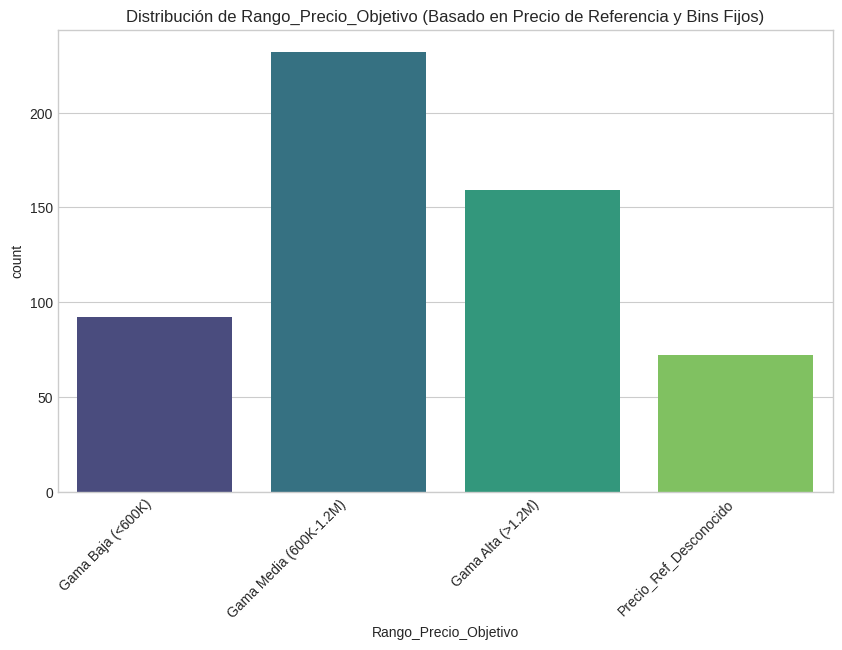

In [ ]:
print("\n--- 3. CREACIÓN DE VARIABLE OBJETIVO: Rango_Precio_Objetivo ---")
df['Precio_Referencia'] = df[['Precio Anterior', 'Precio Internet', 'Precio Descuento']].max(axis=1)
print(f"\nDescripción de 'Precio_Referencia':")
print(df['Precio_Referencia'].describe())

# Guardar las filas que tienen Precio_Referencia NaN para revisarlas después o excluirlas del modelado.
df_sin_precio_referencia = df[df['Precio_Referencia'].isnull()].copy()
print(f"\nNúmero de filas SIN Precio_Referencia (serán 'Precio_Ref_Desconocido'): {len(df_sin_precio_referencia)}")

global labels
labels = []

# Definición de Rangos (según tus especificaciones)
# economico: <500K -> <600K
# gama media: 500K-800K -> 600K-1.2M
# gama alta: 800K-1.7M -> >1.2M
# premium: >1.7M -> ELIMINAR
# Los precios en tu CSV están en unidades (ej. 6699900.0 es 6.699.900)
# Adaptamos los bins a la escala de tus datos:
bins = [0, 600000, 1200000, np.inf] # <500.000, 500.000-800.000, 800.000-1.700.000, >1.700.000
labels = ['Gama Baja (<600K)', 'Gama Media (600K-1.2M)', 'Gama Alta (>1.2M)']

print(f"\nUsando bins fijos definidos: {bins} y labels: {labels} para pd.cut sobre 'Precio_Referencia'")

# Aplicar pd.cut usando los bins definidos
# Solo aplicar a las filas que tienen un Precio_Referencia válido
df_con_precio_referencia = df.dropna(subset=['Precio_Referencia']).copy()

if not df_con_precio_referencia.empty:
    df_con_precio_referencia['Rango_Precio_Objetivo_calc'] = pd.cut(
        df_con_precio_referencia['Precio_Referencia'],
        bins=bins,
        labels=labels,
        right=False,        # Intervalos [a, b) -> <500K significa [0, 500000)
        include_lowest=True # Incluye el valor más bajo (0 en este caso)
    )
    # Unir la nueva columna de rangos al DataFrame original
    df = df.merge(df_con_precio_referencia[['Rango_Precio_Objetivo_calc']],
                  left_index=True,
                  right_index=True,
                  how='left')
    df.rename(columns={'Rango_Precio_Objetivo_calc': 'Rango_Precio_Objetivo'}, inplace=True)
else:
    print("No hay datos con Precio_Referencia válido para crear los rangos.")
    df['Rango_Precio_Objetivo'] = np.nan # Crear la columna con NaNs si no hay datos


print(f"\n--- Rangos de Precio (Rango_Precio_Objetivo) creados (Antes de imputar NaNs) ---")
if 'Rango_Precio_Objetivo' in df.columns:
    print(df['Rango_Precio_Objetivo'].value_counts(dropna=False))
else:
    print("Columna 'Rango_Precio_Objetivo' no fue creada.")


# Manejar NaNs en Rango_Precio_Objetivo (que vienen de Precio_Referencia NaN o si pd.cut no asignó)
if 'Rango_Precio_Objetivo' in df.columns and df['Rango_Precio_Objetivo'].isnull().any():
    # Asegurar que la columna sea de tipo category antes de añadir categorías
    if not pd.api.types.is_categorical_dtype(df['Rango_Precio_Objetivo']):
         # Si pd.cut no asignó ninguna etiqueta (ej. todos los precios fuera de rango), puede ser float (NaN)
         # Convertir a string para manejar NaNs y luego a category
         df['Rango_Precio_Objetivo'] = df['Rango_Precio_Objetivo'].astype(str).fillna('Precio_Ref_Desconocido').astype('category')
    else: # Ya es categórico
        if 'Precio_Ref_Desconocido' not in df['Rango_Precio_Objetivo'].cat.categories:
             df['Rango_Precio_Objetivo'] = df['Rango_Precio_Objetivo'].cat.add_categories(['Precio_Ref_Desconocido'])
        df['Rango_Precio_Objetivo'].fillna('Precio_Ref_Desconocido', inplace=True)
    print(f"NaNs en 'Rango_Precio_Objetivo' etiquetados como 'Precio_Ref_Desconocido'.")
elif 'Rango_Precio_Objetivo' not in df.columns: # Si la creación falló completamente antes
    df['Rango_Precio_Objetivo'] = "Desconocido_Target"
    df['Rango_Precio_Objetivo'] = df['Rango_Precio_Objetivo'].astype('category')
    labels = ["Desconocido_Target"] # Actualizar labels global si falla todo


df['Rango_Precio_Objetivo'] = df['Rango_Precio_Objetivo'].astype('category')
print(f"\n--- Distribución final de Rango_Precio_Objetivo ---")
print(df['Rango_Precio_Objetivo'].value_counts(dropna=False))

plt.figure(figsize=(10, 6))
try:
    plot_order_cats = labels[:]
    # Añadir 'Precio_Ref_Desconocido' al orden si existe como categoría
    if 'Precio_Ref_Desconocido' in df['Rango_Precio_Objetivo'].cat.categories and 'Precio_Ref_Desconocido' not in plot_order_cats:
        plot_order_cats.append('Precio_Ref_Desconocido')

    # Filtrar plot_order_cats para que solo contenga categorías presentes en los datos
    plot_order_cats_present = [cat for cat in plot_order_cats if cat in df['Rango_Precio_Objetivo'].unique()]

    sns.countplot(x=df['Rango_Precio_Objetivo'].cat.reorder_categories(plot_order_cats_present, ordered=True), palette="viridis")
except Exception as e:
    print(f"Error al graficar Rango_Precio_Objetivo con orden: {e}. Graficando sin orden.")
    sns.countplot(x=df['Rango_Precio_Objetivo'].astype(str), palette="viridis")

plt.title("Distribución de Rango_Precio_Objetivo (Basado en Precio de Referencia y Bins Fijos)")
plt.xticks(rotation=45, ha='right')
plt.show()

## 3.4 SIMPLIFICACIÓN Y AGRUPACIÓN DE FEATURES CATEGÓRICOS

In [ ]:
print("\n--- 4. SIMPLIFICACIÓN Y AGRUPACIÓN DE FEATURES CATEGÓRICOS ---")

def simplify_processor_v4(proc_text):
    if pd.isna(proc_text): return "Desconocido"
    text = str(proc_text).lower()
    text = text.replace('™', '').replace('®', '')
    text = re.sub(r'processor', '', text, flags=re.IGNORECASE).strip()
    text = re.sub(r'procesador', '', text, flags=re.IGNORECASE).strip()
    text = re.sub(r'chip', '', text, flags=re.IGNORECASE).strip()
    text = re.sub(r'\s+', ' ', text)

    if "apple" in text or text.startswith("m1") or text.startswith("m2") or text.startswith("m3") or text.startswith("m4"):
        if "m4 pro" in text: return "Apple M4 Pro"
        if "m4 max" in text: return "Apple M4 Max"
        if "m4 ultra" in text: return "Apple M4 Ultra"
        if "m4" in text: return "Apple M4"
        if "m3 pro" in text: return "Apple M3 Pro"
        if "m3 max" in text: return "Apple M3 Max"
        if "m3 ultra" in text: return "Apple M3 Ultra"
        if "m3" in text: return "Apple M3"
        if "m2 pro" in text: return "Apple M2 Pro"
        if "m2 max" in text: return "Apple M2 Max"
        if "m2 ultra" in text: return "Apple M2 Ultra"
        if "m2" in text: return "Apple M2"
        if "m1 pro" in text: return "Apple M1 Pro"
        if "m1 max" in text: return "Apple M1 Max"
        if "m1 ultra" in text: return "Apple M1 Ultra"
        if "m1" in text: return "Apple M1"
        return "Apple Otro"

    if "intel core ultra 9" in text: return "Intel Core Ultra 9"
    if "intel core ultra 7" in text: return "Intel Core Ultra 7"
    if "intel core ultra 5" in text: return "Intel Core Ultra 5"
    if "intel core ultra" in text: return "Intel Core Ultra Otro"

    core_ix_match = re.search(r'intel\s*core\s*(i[3579](?:-|\s)?\d{2,5}[a-z]{0,3}(?:h|u|g\d|hx|k|f|p)?)', text)
    if core_ix_match:
        return f"Intel Core {core_ix_match.group(1).replace(' ', '').upper()}"

    if "intel core i9" in text: return "Intel Core i9"
    if "intel core i7" in text: return "Intel Core i7"
    if "intel core i5" in text: return "Intel Core i5"
    if "intel core i3" in text: return "Intel Core i3"

    ryzen_match = re.search(r'amd\s*ryzen\s*(?:ai\s*)?([3579](?:\s*pro)?(?:-|\s)?\d{3,4}[a-z]{0,3}x?s?)', text)
    if ryzen_match:
        return f"AMD Ryzen {ryzen_match.group(1).replace(' ', '').upper()}"

    if "amd ryzen 9" in text or "r9" in text : return "AMD Ryzen 9"
    if "amd ryzen 7" in text or "r7" in text : return "AMD Ryzen 7"
    if "amd ryzen 5" in text or "r5" in text : return "AMD Ryzen 5"
    if "amd ryzen 3" in text or "r3" in text : return "AMD Ryzen 3"

    if "intel celeron" in text:
        celeron_n_match = re.search(r'celeron\s*(n\d{4})', text)
        return f"Intel Celeron {celeron_n_match.group(1).upper()}" if celeron_n_match else "Intel Celeron"
    if "intel pentium" in text:
        pentium_n_match = re.search(r'pentium\s*((?:silver|gold)\s*n?\d{4})', text)
        return f"Intel Pentium {pentium_n_match.group(1).upper()}" if pentium_n_match else "Intel Pentium"

    n_series_match = re.search(r'intel\s*(n\d{3,4})', text)
    if n_series_match:
        return f"Intel Entry ({n_series_match.group(1).upper()})"

    if "snapdragon" in text:
        snap_match = re.search(r'snapdragon(?:\s*x\s*elite|\s*\d\w*\s*gen\s*\d|\s*\d{3}\w*)?', text)
        return snap_match.group(0).replace("snapdragon ", "Snapdragon ").strip() if snap_match else "Snapdragon"
    if "qualcomm" in text: return "Qualcomm Otro"

    if "amd" in text: return "AMD Otro"
    if "intel" in text: return "Intel Otro"

    return "Desconocido"


if 'Procesador' in df.columns:
    df['Procesador_Familia'] = df['Procesador'].apply(simplify_processor_v4)
    print("\n--- Procesadores Originales que resultaron en 'Desconocido' con v4 ---")
    desconocidos_df = df[df['Procesador_Familia'] == 'Desconocido']
    if not desconocidos_df.empty:
        print(desconocidos_df[['Procesador', 'Nombre_Original_Producto']].head(20))
    else:
        print("¡Excelente! Ningún procesador resultó en 'Desconocido' con v4 (excl. NaNs originales).")

    proc_counts = df['Procesador_Familia'].value_counts()
    threshold_proc = 5 # Puedes ajustar este umbral
    proc_raros = proc_counts[proc_counts < threshold_proc].index
    df['Procesador_Grupo'] = df['Procesador_Familia'].replace(proc_raros, 'Otro_Procesador_Agrupado')
    if 'Desconocido' in proc_counts.index and proc_counts['Desconocido'] >= threshold_proc:
        df.loc[df['Procesador_Familia'] == 'Desconocido', 'Procesador_Grupo'] = 'Desconocido'
    print("\nProcesador_Grupo Creado (después de agrupación):")
    print(df['Procesador_Grupo'].value_counts(dropna=False))
else:
    df['Procesador_Familia'] = "Desconocido"
    df['Procesador_Grupo'] = "Desconocido"

def simplify_gpu(gpu_text):
    if pd.isna(gpu_text) or gpu_text.lower() in ['no posee / integrada', 'no posee']:
        return "Integrada/No Dedicada"
    gpu_text = str(gpu_text).lower()
    if "rtx 4090" in gpu_text: return "NVIDIA RTX 4090"
    if "rtx 4080" in gpu_text: return "NVIDIA RTX 4080"
    if "rtx 4070" in gpu_text: return "NVIDIA RTX 4070"
    if "rtx 4060" in gpu_text: return "NVIDIA RTX 4060"
    if "rtx 4050" in gpu_text: return "NVIDIA RTX 4050"
    if "rtx 3080" in gpu_text: return "NVIDIA RTX 3080"
    if "rtx 3070" in gpu_text: return "NVIDIA RTX 3070"
    if "rtx 3060" in gpu_text: return "NVIDIA RTX 3060"
    if "rtx 3050" in gpu_text: return "NVIDIA RTX 3050"
    if "rtx 2050" in gpu_text: return "NVIDIA RTX 2050"
    if "rtx 20" in gpu_text: return "NVIDIA RTX 20-series"
    if "gtx 16" in gpu_text: return "NVIDIA GTX 16-series"
    if "nvidia rtx" in gpu_text or "rtx" in gpu_text: return "NVIDIA RTX (Genérica)"
    if "nvidia gtx" in gpu_text or "gtx" in gpu_text: return "NVIDIA GTX (Genérica)"
    if "nvidia quadro" in gpu_text or "quadro" in gpu_text: return "NVIDIA Quadro"
    if "nvidia mx" in gpu_text or "mx" in gpu_text: return "NVIDIA MX"
    if "nvidia geforce" in gpu_text or "nvidia" in gpu_text: return "NVIDIA Otra Dedicada"
    if "amd radeon rx" in gpu_text or "rx" in gpu_text and "amd" in gpu_text : return "AMD Radeon RX"
    if "amd radeon" in gpu_text: return "AMD Radeon Dedicada (Otra)"
    if "intel iris xe" in gpu_text or "iris xe" in gpu_text : return "Intel Iris Xe (Integrada)"
    if "intel arc" in gpu_text: return "Intel Arc Dedicada"
    if "intel uhd" in gpu_text or "intel graphics" in gpu_text : return "Intel Integrada Genérica"
    if "amd" in gpu_text: return "AMD Integrada/Otra Dedicada"
    return "Otra_Grafica_Dedicada"

if 'Tarjeta_Grafica' in df.columns:
    df['Tarjeta_Grafica_Grupo'] = df['Tarjeta_Grafica'].apply(simplify_gpu)
    gpu_counts = df['Tarjeta_Grafica_Grupo'].value_counts()
    threshold_gpu = 5
    gpu_raras = gpu_counts[gpu_counts < threshold_gpu].index
    df['Tarjeta_Grafica_Grupo'] = df['Tarjeta_Grafica_Grupo'].replace(gpu_raras, 'Otra_Grafica_Agrupada')
    common_gpu_cats_restore = ['Integrada/No Dedicada', 'Intel Integrada Genérica', 'Intel Iris Xe (Integrada)', 'NVIDIA RTX 2050']
    for cat in common_gpu_cats_restore:
        # Aplicar simplify_gpu a la columna original para la comparación
        original_gpu_simplified = df['Tarjeta_Grafica'].apply(lambda x: simplify_gpu(x) if pd.notna(x) else 'Integrada/No Dedicada')
        mask_original_cat = (original_gpu_simplified == cat)
        # Restaurar si la categoría original simplificada era esta Y ahora está agrupada
        df.loc[mask_original_cat & (df['Tarjeta_Grafica_Grupo'] == 'Otra_Grafica_Agrupada'), 'Tarjeta_Grafica_Grupo'] = cat
    print("\nTarjeta_Grafica_Grupo Creado (después de agrupación):")
    print(df['Tarjeta_Grafica_Grupo'].value_counts(dropna=False))
else:
    df['Tarjeta_Grafica_Grupo'] = "Desconocido"

if 'Marca' in df.columns:
    marca_counts = df['Marca'].value_counts()
    threshold_marca = 5
    marcas_raras = marca_counts[marca_counts < threshold_marca].index
    df['Marca_Grupo'] = df['Marca'].replace(marcas_raras, 'Otra_Marca')
    print("\nMarca_Grupo Creado:")
    print(df['Marca_Grupo'].value_counts(dropna=False))
else:
    df['Marca_Grupo'] = "Desconocido"


--- 4. SIMPLIFICACIÓN Y AGRUPACIÓN DE FEATURES CATEGÓRICOS ---

--- Procesadores Originales que resultaron en 'Desconocido' con v4 ---
    Procesador                           Nombre_Original_Producto
51         NaN  Ideapad 5 9 Ultra 9 185H + " 2.5K 120HZ ARC Gr...
61         NaN                     Notebook Gamer xf0005la R9 8GB
71         NaN                   NOTEBOOK 245 G9 R3 3250U W11Home
77         NaN                     Macbook Air 2019 '' Plateado .
82         NaN                              Notebook E41 55 W 10H
84         NaN  Yoga Book 9i Ultra 7 155U + " 2.8K 400N + Inte...
98         NaN  Ideapad Slim 5 9 Ultra 5 125H + 14" 300N ARC G...
104        NaN                       Notebook 245 G9 AMD R3 3250U
110        NaN                   NOTEBOOK IDEAPAD HD DISCO SOLIDO
117        NaN                                            MacBook
161        NaN                                   MacBook Air 2020
167        NaN                           Notebook thinkpad Carbon
175   

##3.5 ANÁLISIS EXPLORATORIO UNIVARIADO (Features para Modelo)


--- 5. ANÁLISIS UNIVARIADO DE FEATURES PARA MODELO ---

--- Distribuciones de Features Numéricos para Modelo ---


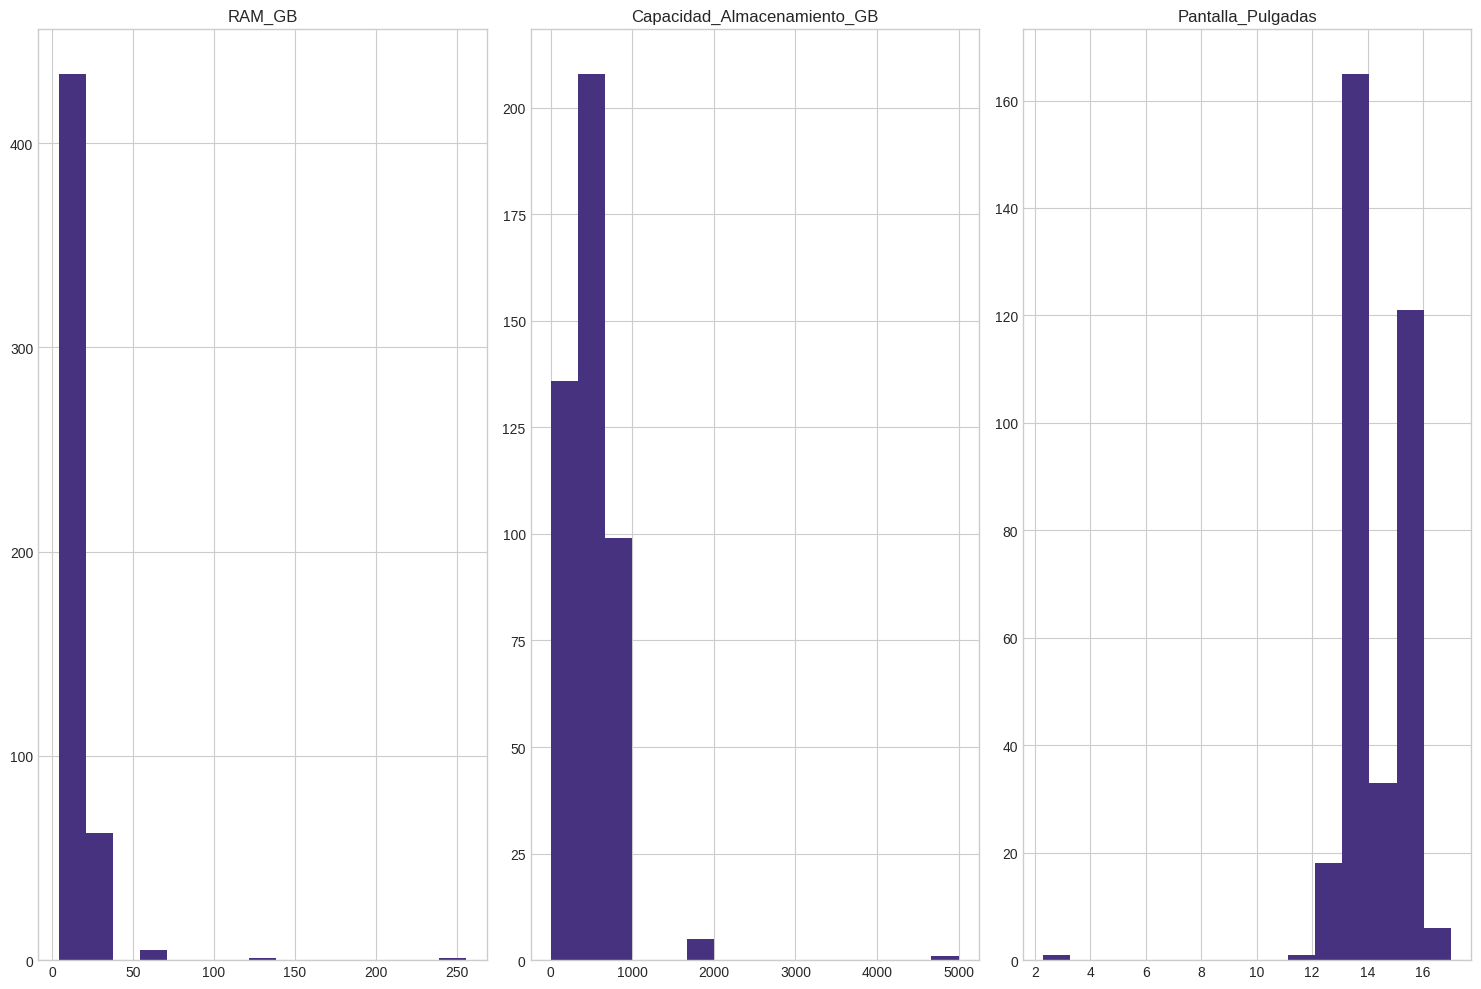


--- Boxplots de Features Numéricos para Modelo ---


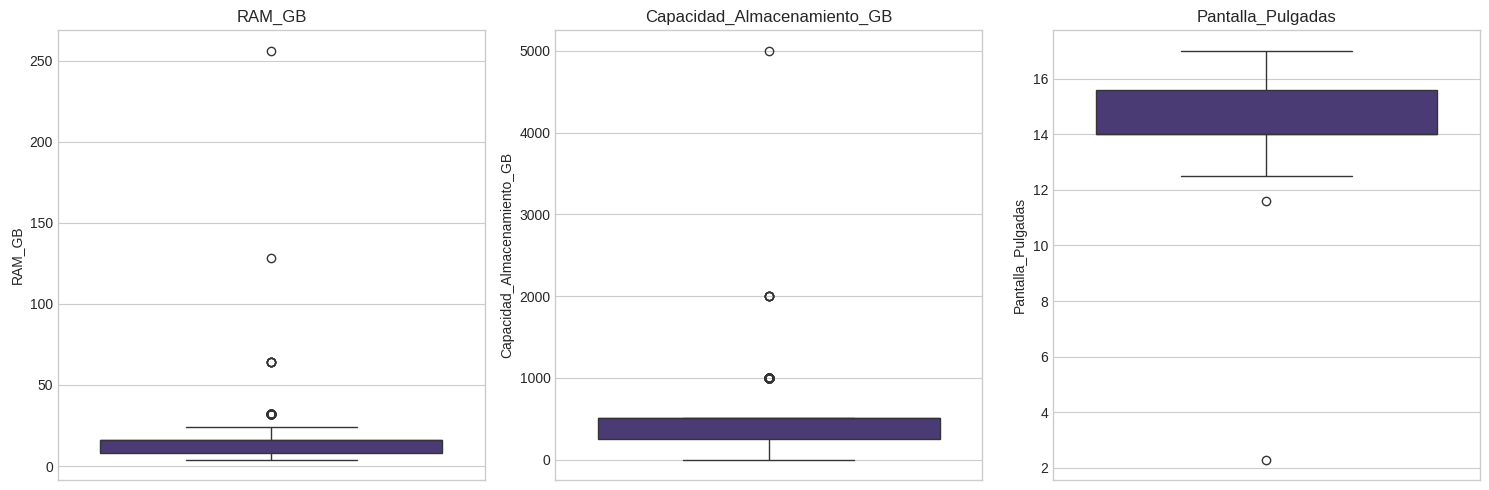


Asimetría de Features Numéricos para Modelo:
RAM_GB                         9.574219
Capacidad_Almacenamiento_GB    4.124998
Pantalla_Pulgadas             -3.112144
dtype: float64

--- Distribuciones de Features Categóricos para Modelo ---


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


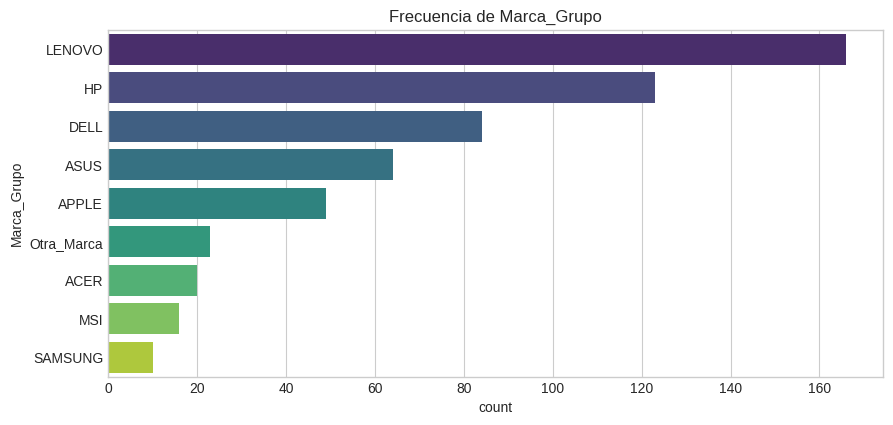

Marca_Grupo
LENOVO        166
HP            123
DELL           84
ASUS           64
APPLE          49
Otra_Marca     23
ACER           20
MSI            16
SAMSUNG        10
Name: count, dtype: int64


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


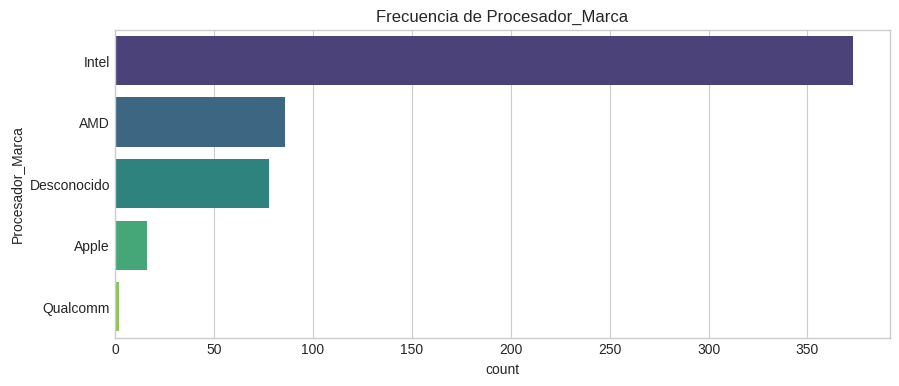

Procesador_Marca
Intel          373
AMD             86
Desconocido     78
Apple           16
Qualcomm         2
Name: count, dtype: int64


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


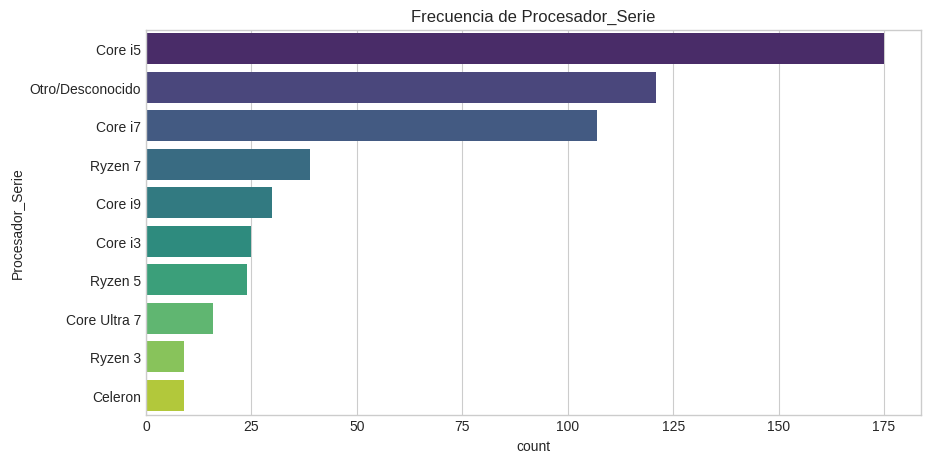

Procesador_Serie
Core i5             175
Otro/Desconocido    121
Core i7             107
Ryzen 7              39
Core i9              30
Core i3              25
Ryzen 5              24
Core Ultra 7         16
Ryzen 3               9
Celeron               9
Name: count, dtype: int64


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


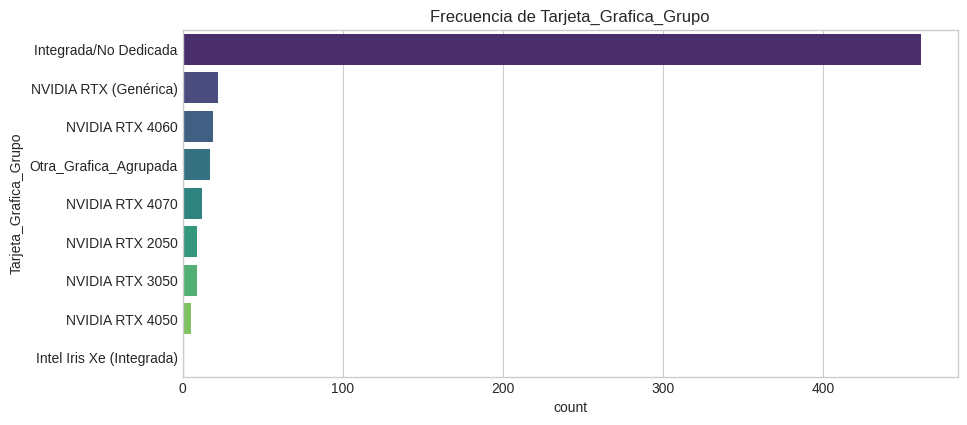

Tarjeta_Grafica_Grupo
Integrada/No Dedicada        461
NVIDIA RTX (Genérica)         22
NVIDIA RTX 4060               19
Otra_Grafica_Agrupada         17
NVIDIA RTX 4070               12
NVIDIA RTX 2050                9
NVIDIA RTX 3050                9
NVIDIA RTX 4050                5
Intel Iris Xe (Integrada)      1
Name: count, dtype: int64


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


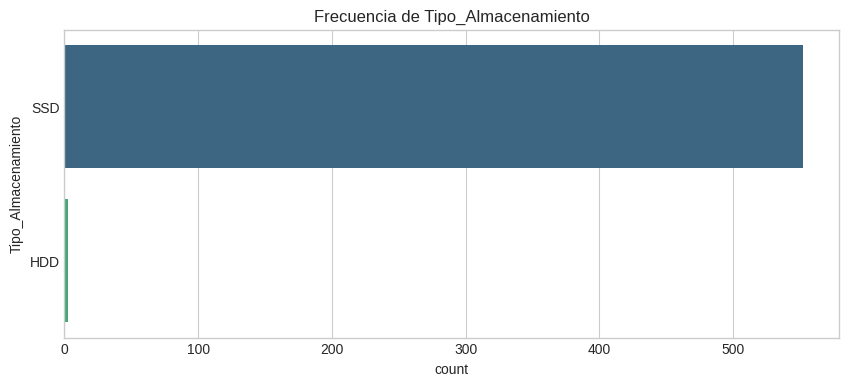

Tipo_Almacenamiento
SSD    552
HDD      3
Name: count, dtype: int64


/tmp/ipython-input-296-555315044.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")


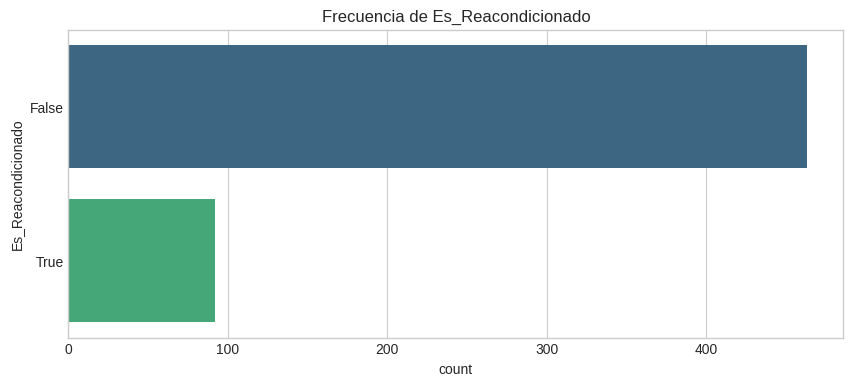

Es_Reacondicionado
False    463
True      92
Name: count, dtype: int64


In [ ]:
print("\n--- 5. ANÁLISIS UNIVARIADO DE FEATURES PARA MODELO ---")
model_numeric_features = ['RAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']
model_numeric_features = [col for col in model_numeric_features if col in df.columns and df[col].notna().any()]

model_categorical_features_final = ['Marca_Grupo', 'Procesador_Marca', 'Procesador_Serie', 'Tarjeta_Grafica_Grupo', 'Tipo_Almacenamiento', 'Es_Reacondicionado']
model_categorical_features_final = [col for col in model_categorical_features_final if col in df.columns and df[col].notna().any()]

if model_numeric_features:
    print("\n--- Distribuciones de Features Numéricos para Modelo ---")
    df[model_numeric_features].hist(bins=15, figsize=(15, 10), layout=(-1, 3))
    plt.tight_layout()
    plt.show()
    print("\n--- Boxplots de Features Numéricos para Modelo ---")
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(model_numeric_features):
        plt.subplot(1, len(model_numeric_features), i+1)
        sns.boxplot(y=df[col].dropna())
        plt.title(col)
    plt.tight_layout()
    plt.show()
    skew_values_model = df[model_numeric_features].apply(lambda x: skew(x.dropna()) if not x.dropna().empty else np.nan)
    print(f"\nAsimetría de Features Numéricos para Modelo:\n{skew_values_model}")

if model_categorical_features_final:
    print("\n--- Distribuciones de Features Categóricos para Modelo ---")
    for col in model_categorical_features_final:
        if df[col].astype(str).nunique() == 0 : continue
        plt.figure(figsize=(10, max(4, df[col].astype(str).nunique()*0.5) ))
        sns.countplot(y=df[col].astype(str), order=df[col].astype(str).value_counts().index, palette="viridis")
        plt.title(f"Frecuencia de {col}")
        plt.show()
        print(df[col].value_counts(dropna=False))

##3.6 ANÁLISIS EXPLORATORIO BIVARIADO (Features vs Rango_Precio)


--- 6. ANÁLISIS BIVARIADO (FEATURES VS Rango_Precio_Objetivo) ---
Análisis bivariado con 'Rango_Precio_Objetivo' (Categorías válidas: 3)
Rango_Precio_Objetivo
Gama Media (600K-1.2M)    232
Gama Alta (>1.2M)         159
Gama Baja (<600K)          92
Name: count, dtype: int64

--- Features Numéricos vs. Rango_Precio_Objetivo ---


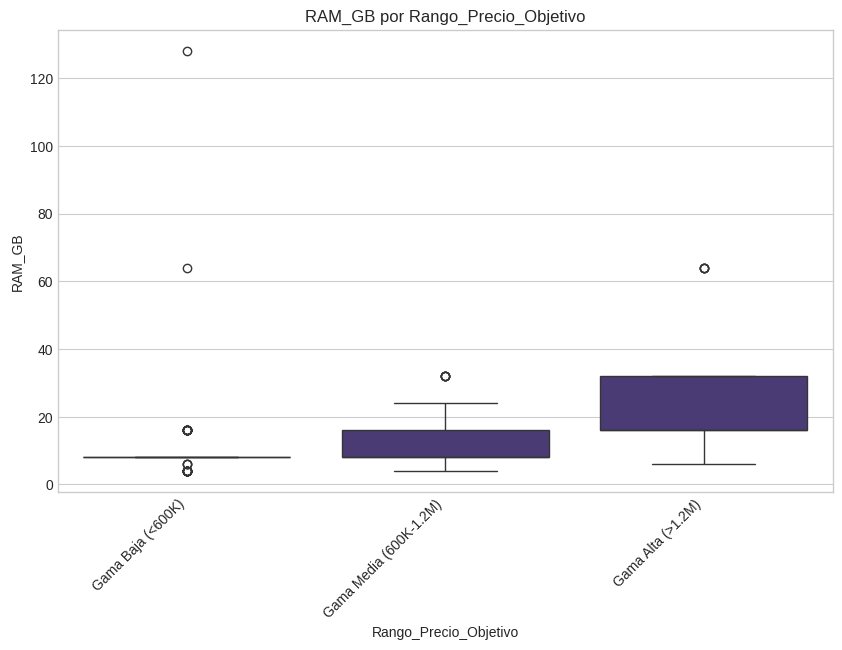

Kruskal-Wallis para RAM_GB y Rango_Precio_Objetivo: p-valor = 0.0000


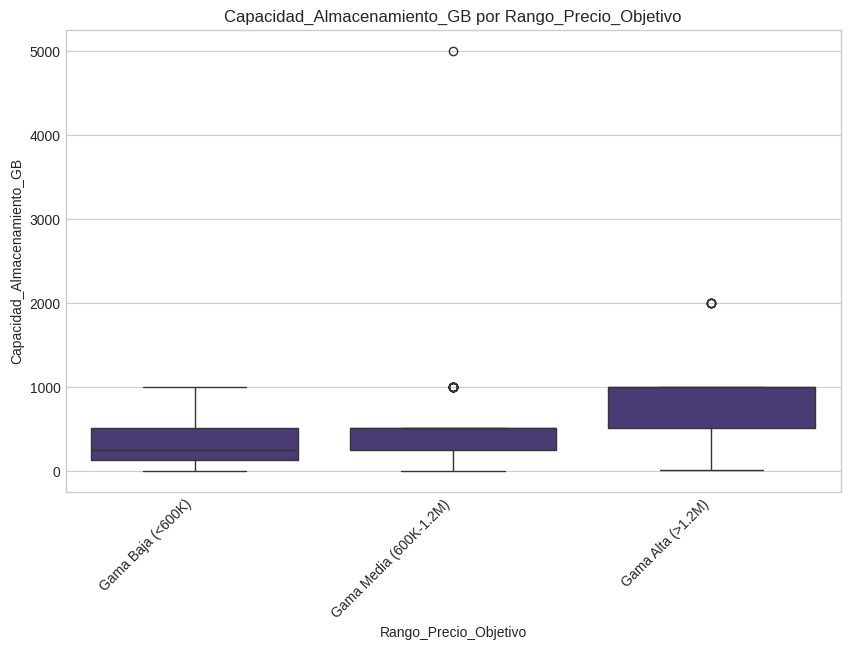

Kruskal-Wallis para Capacidad_Almacenamiento_GB y Rango_Precio_Objetivo: p-valor = 0.0000


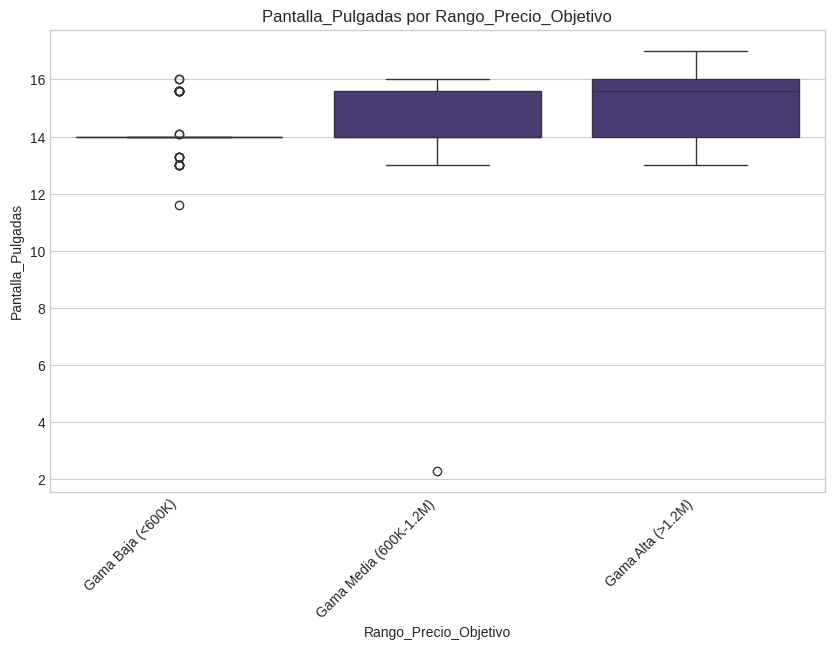

Kruskal-Wallis para Pantalla_Pulgadas y Rango_Precio_Objetivo: p-valor = 0.0000

--- Features Categóricos vs. Rango_Precio_Objetivo ---


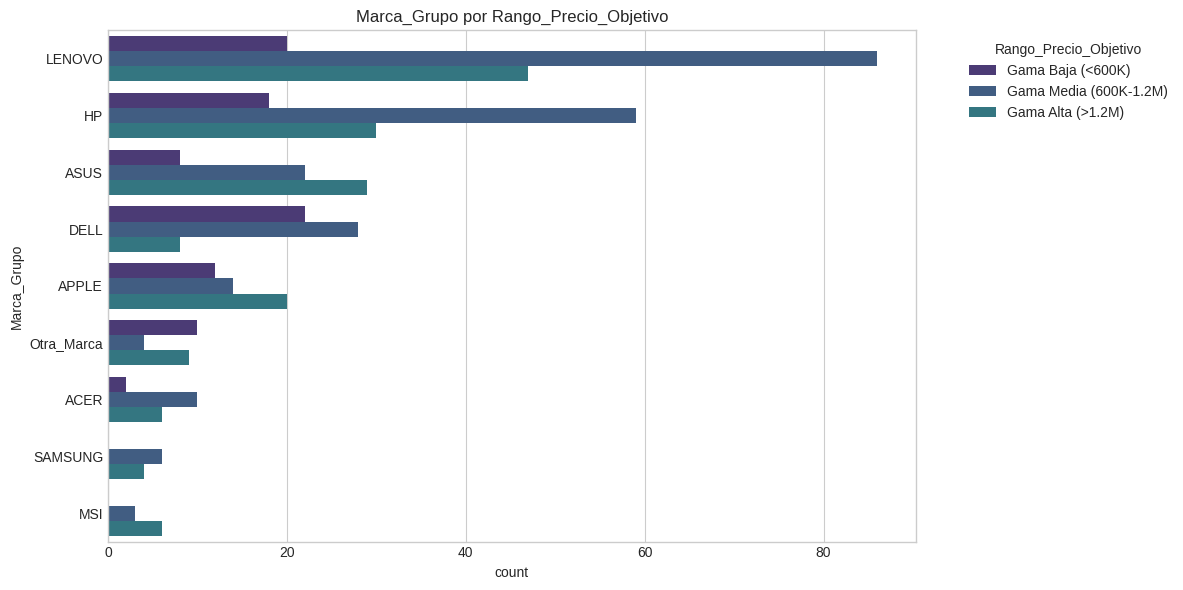

Test Chi-cuadrado para Marca_Grupo y Rango_Precio_Objetivo: p-valor = 0.0000


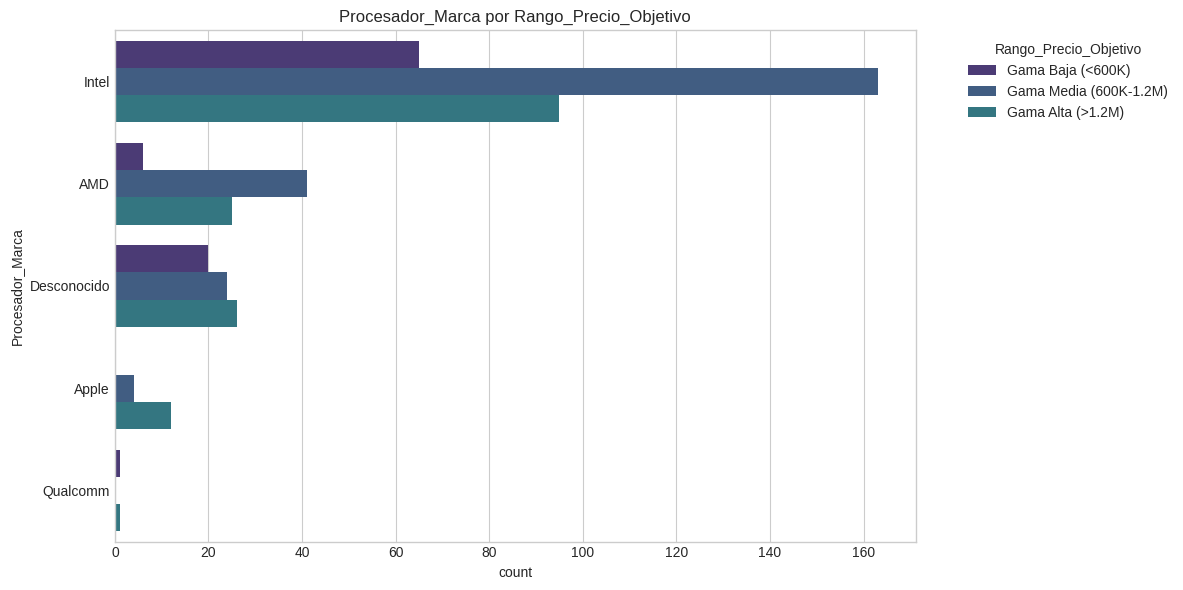

Test Chi-cuadrado para Procesador_Marca y Rango_Precio_Objetivo: p-valor = 0.0003


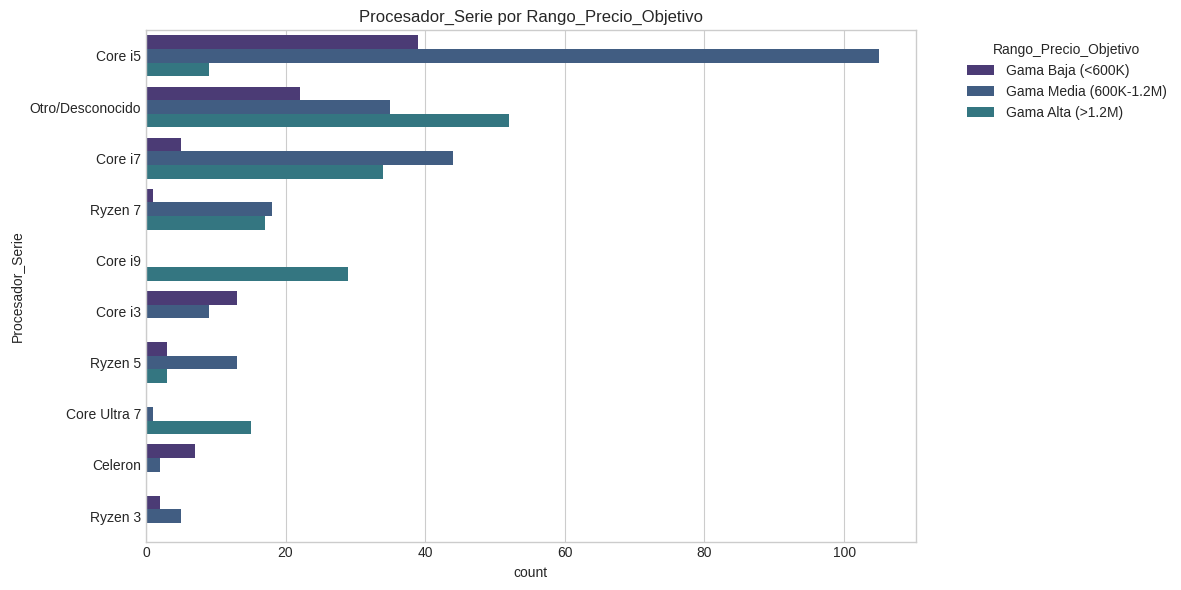

Test Chi-cuadrado para Procesador_Serie y Rango_Precio_Objetivo: p-valor = 0.0000


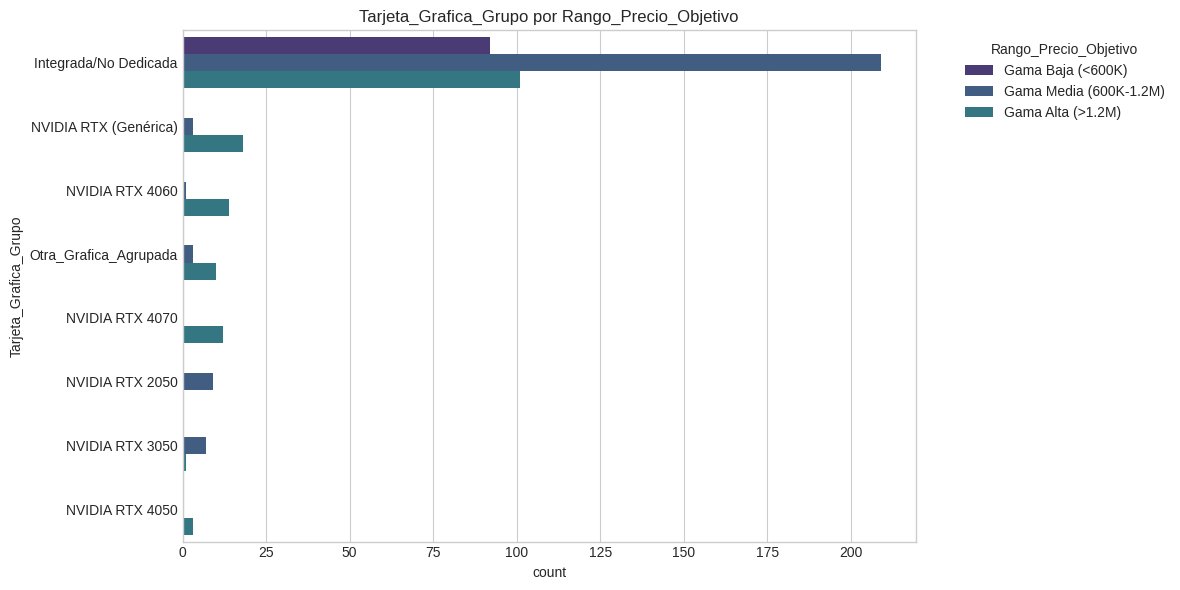

Test Chi-cuadrado para Tarjeta_Grafica_Grupo y Rango_Precio_Objetivo: p-valor = 0.0000


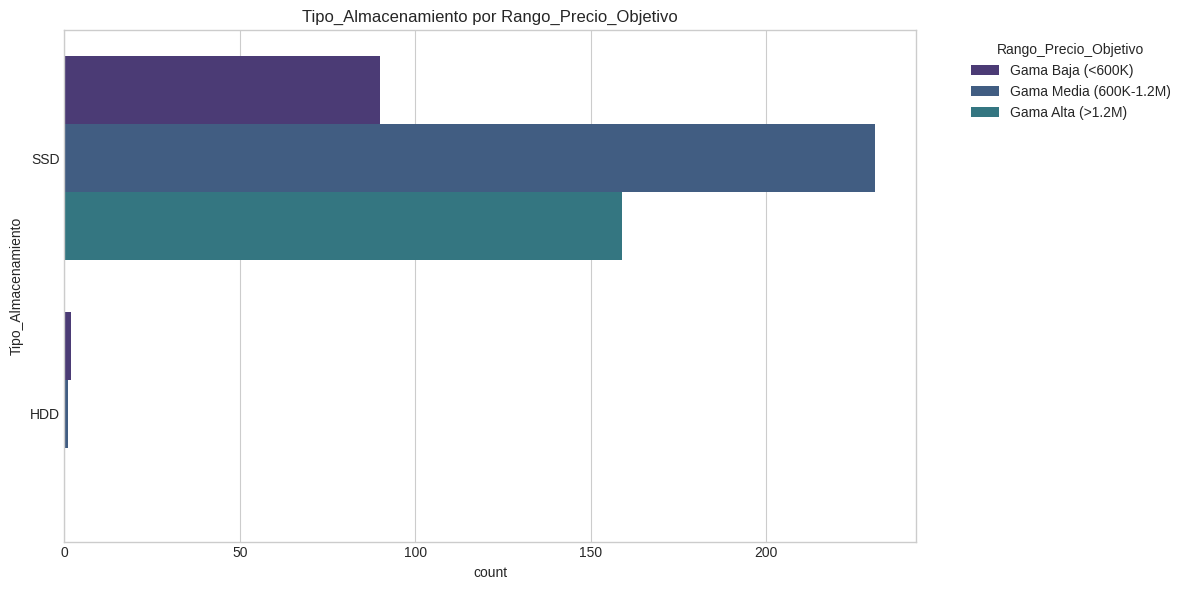

Test Chi-cuadrado para Tipo_Almacenamiento y Rango_Precio_Objetivo: p-valor = 0.0943


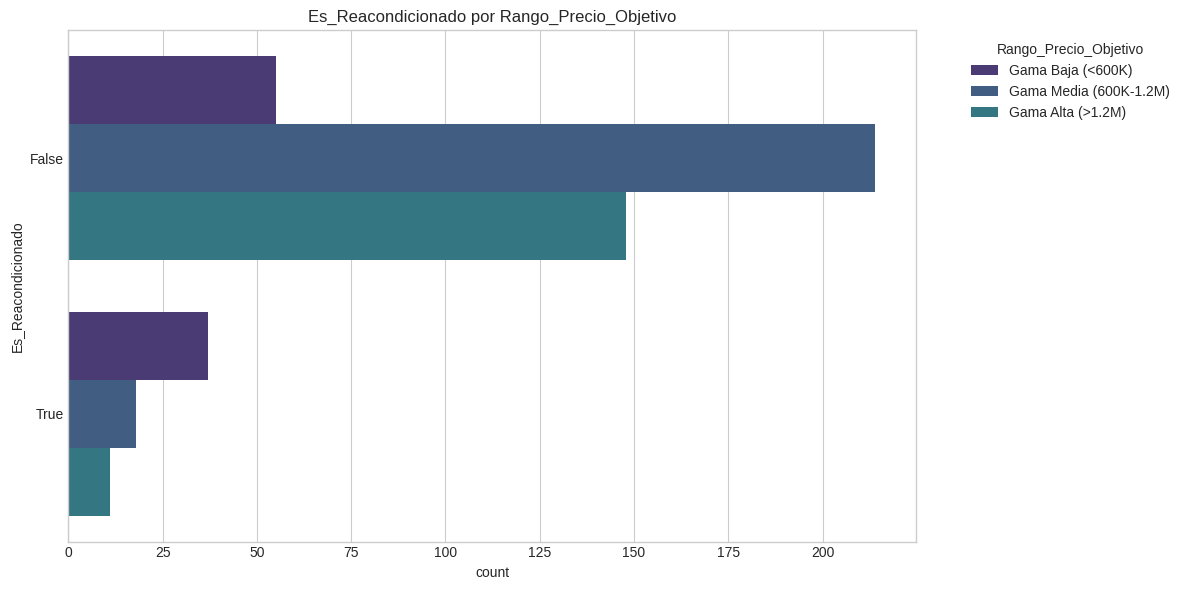

Test Chi-cuadrado para Es_Reacondicionado y Rango_Precio_Objetivo: p-valor = 0.0000


In [ ]:
print("\n--- 6. ANÁLISIS BIVARIADO (FEATURES VS Rango_Precio_Objetivo) ---")
target_col_eda = 'Rango_Precio_Objetivo'
df_bivariate = df[df[target_col_eda].notna()].copy()

# Solo proceder si hay categorías válidas después de quitar 'Precio_Ref_Desconocido'
valid_categories_for_bivariate = df_bivariate[target_col_eda].cat.categories.tolist()
if 'Precio_Ref_Desconocido' in valid_categories_for_bivariate:
    valid_categories_for_bivariate.remove('Precio_Ref_Desconocido')

if not df_bivariate.empty and len(valid_categories_for_bivariate) >= 2:
    df_bivariate = df_bivariate[df_bivariate[target_col_eda].isin(valid_categories_for_bivariate)]
    df_bivariate[target_col_eda] = df_bivariate[target_col_eda].cat.remove_unused_categories() # Actualizar categorías

    print(f"Análisis bivariado con '{target_col_eda}' (Categorías válidas: {df_bivariate[target_col_eda].nunique()})")
    print(df_bivariate[target_col_eda].value_counts(dropna=False))

    if model_numeric_features:
        print("\n--- Features Numéricos vs. Rango_Precio_Objetivo ---")
        for col in model_numeric_features:
            plt.figure(figsize=(10, 6))
            plot_order_biv = df_bivariate[target_col_eda].cat.categories.tolist()
            sns.boxplot(data=df_bivariate, x=target_col_eda, y=col, order=plot_order_biv)
            plt.title(f'{col} por {target_col_eda}')
            plt.xticks(rotation=45, ha='right')
            plt.show()
            if df_bivariate[col].notna().sum() > 0:
                groups = [df_bivariate[col][df_bivariate[target_col_eda] == rango].dropna() for rango in plot_order_biv if df_bivariate[col][df_bivariate[target_col_eda] == rango].notna().sum() > 1]
                if len(groups) > 1:
                    try:
                        stat, p_kruskal = kruskal(*groups)
                        print(f"Kruskal-Wallis para {col} y {target_col_eda}: p-valor = {p_kruskal:.4f}")
                    except ValueError as e:
                        print(f"No se pudo calcular Kruskal-Wallis para {col} y {target_col_eda}: {e}")

    if model_categorical_features_final:
        print("\n--- Features Categóricos vs. Rango_Precio_Objetivo ---")
        for col in model_categorical_features_final:
            plt.figure(figsize=(12, max(6, df_bivariate[col].astype(str).nunique()*0.4)))
            sns.countplot(data=df_bivariate, y=col, hue=target_col_eda, order=df_bivariate[col].astype(str).value_counts().index)
            plt.title(f'{col} por {target_col_eda}')
            plt.legend(title=target_col_eda, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
            if df_bivariate[col].nunique() > 1 and df_bivariate[target_col_eda].nunique() > 1:
                contingency_table = pd.crosstab(df_bivariate[col], df_bivariate[target_col_eda])
                if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1 and contingency_table.size > 0 :
                    try:
                        chi2, p_chi, dof, expected = chi2_contingency(contingency_table)
                        print(f"Test Chi-cuadrado para {col} y {target_col_eda}: p-valor = {p_chi:.4f}")
                    except ValueError as e:
                        print(f"No se pudo calcular Chi-cuadrado para {col} y {target_col_eda}: {e}.")
                else:
                    print(f"Tabla de contingencia no válida para {col} y {target_col_eda} (dims: {contingency_table.shape}).")
else:
    print(f"La variable objetivo '{target_col_eda}' no es adecuada para análisis bivariado después de filtrar (pocas categorías válidas).")
    if target_col_eda in df.columns:
        print(df[target_col_eda].value_counts(dropna=False))

In [ ]:
print(df.shape)
print(df.dtypes)

(555, 21)
Marca                            object
Precio Descuento                float64
Precio Internet                 float64
Precio Anterior                 float64
RAM_GB                          float64
Tipo_Almacenamiento              object
Capacidad_Almacenamiento_GB     float64
Tarjeta_Grafica                  object
Pantalla_Pulgadas               float64
Procesador                       object
Es_Reacondicionado                 bool
Producto                         object
Procesador_Marca                 object
Procesador_Serie                 object
Nombre_Original_Producto         object
Precio_Referencia               float64
Rango_Precio_Objetivo          category
Procesador_Familia               object
Procesador_Grupo                 object
Tarjeta_Grafica_Grupo            object
Marca_Grupo                      object
dtype: object


## 3.6.1 Eliminación de Outliers

--- 3.6.1 Eliminación de Outliers usando el método IQR ---
Número de filas antes de eliminar outliers: 555

Analizando 'RAM_GB':
  Q1=8.00, Q3=16.00, IQR=8.00
  Límites válidos: [-4.00, 28.00]
  Outliers detectados: 61
  Filas eliminadas: 61

Analizando 'Capacidad_Almacenamiento_GB':
  Q1=256.00, Q3=512.00, IQR=256.00
  Límites válidos: [-128.00, 896.00]
  Outliers detectados: 59
  Filas eliminadas: 59

Analizando 'Pantalla_Pulgadas':
  Q1=14.00, Q3=15.60, IQR=1.60
  Límites válidos: [11.60, 18.00]
  Outliers detectados: 2
  Filas eliminadas: 2

Número total de filas después de eliminar outliers: 433
Total de filas eliminadas: 122

--- Boxplots después de la eliminación de outliers ---


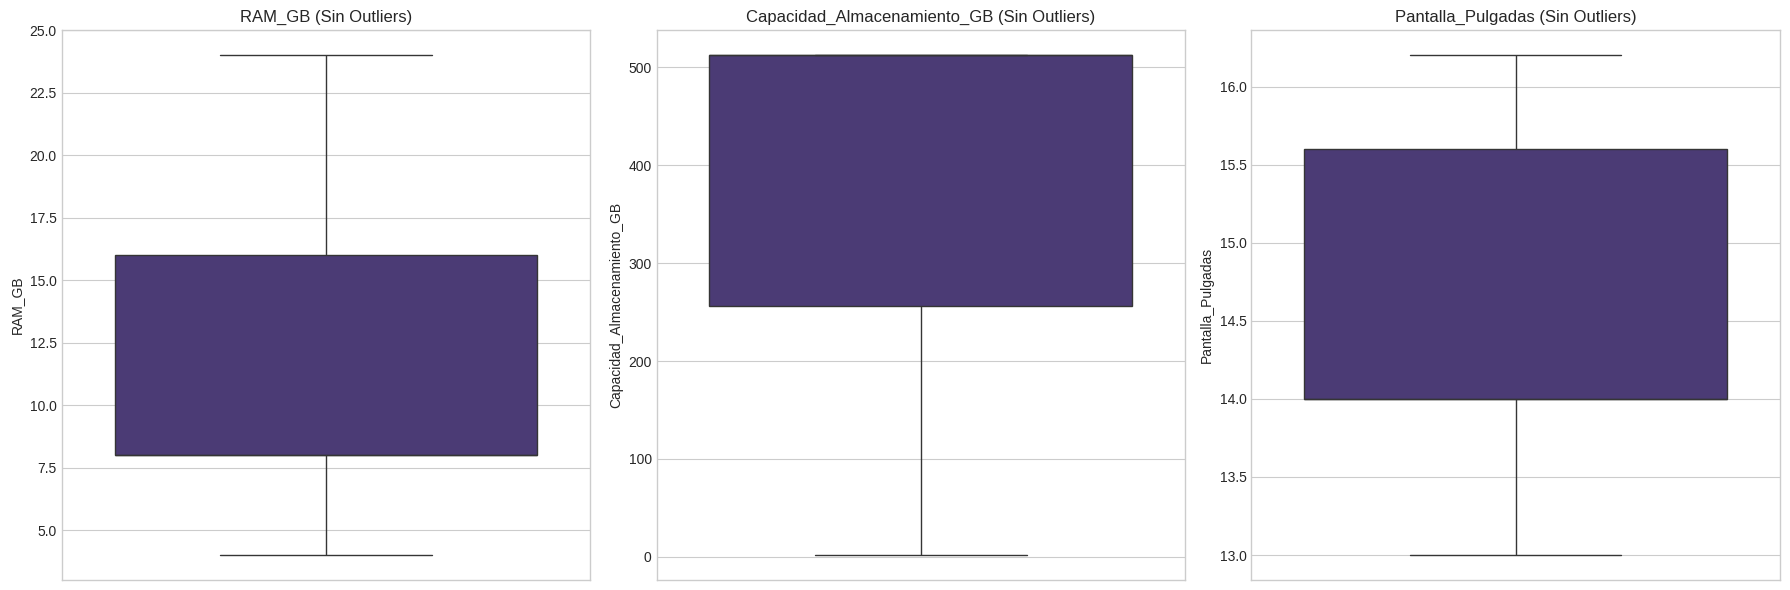


Reemplazando el DataFrame original 'df' con la versión sin outliers.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- 3.6.1 Eliminación de Outliers usando el método IQR ---")

# Hacemos una copia para no modificar el DataFrame original en el proceso
df_no_outliers = df.copy()
print(f"Número de filas antes de eliminar outliers: {len(df_no_outliers)}")

# Lista de columnas a limpiar
features_to_clean = ['RAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']

# Iteramos sobre cada columna para identificar y eliminar outliers
for feature in features_to_clean:
    if feature in df_no_outliers.columns:
        rows_before = len(df_no_outliers)

        # 1. Calcular Q1 y Q3 (ignorando NaNs)
        Q1 = df_no_outliers[feature].quantile(0.25)
        Q3 = df_no_outliers[feature].quantile(0.75)
        IQR = Q3 - Q1

        # 2. Definir límites
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f"\nAnalizando '{feature}':")
        print(f"  Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
        print(f"  Límites válidos: [{lower_bound:.2f}, {upper_bound:.2f}]")

        # Contar cuántos outliers se van a eliminar
        outliers = df_no_outliers[(df_no_outliers[feature] < lower_bound) | (df_no_outliers[feature] > upper_bound)]
        print(f"  Outliers detectados: {len(outliers)}")

        # 3. Filtrar el DataFrame, manteniendo solo los valores dentro de los límites
        # También nos aseguramos de no eliminar filas con NaN en esta columna, ya que las trataremos después
        df_no_outliers = df_no_outliers[
            (df_no_outliers[feature] >= lower_bound) &
            (df_no_outliers[feature] <= upper_bound) |
            (df_no_outliers[feature].isnull())
        ]

        rows_after = len(df_no_outliers)
        print(f"  Filas eliminadas: {rows_before - rows_after}")

print(f"\nNúmero total de filas después de eliminar outliers: {len(df_no_outliers)}")
print(f"Total de filas eliminadas: {len(df) - len(df_no_outliers)}")

# (Opcional pero recomendado) Visualizar los boxplots después de la limpieza
print("\n--- Boxplots después de la eliminación de outliers ---")
plt.figure(figsize=(18, 6))
for i, col in enumerate(features_to_clean):
    if col in df_no_outliers.columns:
        plt.subplot(1, len(features_to_clean), i + 1)
        sns.boxplot(y=df_no_outliers[col].dropna())
        plt.title(f'{col} (Sin Outliers)')
        plt.ylabel(col)
plt.tight_layout()
plt.show()

# IMPORTANTE: Reemplazar el DataFrame original 'df' con el DataFrame limpio
# para que las siguientes celdas del notebook trabajen con los datos sin outliers.
print("\nReemplazando el DataFrame original 'df' con la versión sin outliers.")
df = df_no_outliers.copy()

In [ ]:
print(df.shape)
print(df.dtypes)

(433, 21)
Marca                            object
Precio Descuento                float64
Precio Internet                 float64
Precio Anterior                 float64
RAM_GB                          float64
Tipo_Almacenamiento              object
Capacidad_Almacenamiento_GB     float64
Tarjeta_Grafica                  object
Pantalla_Pulgadas               float64
Procesador                       object
Es_Reacondicionado                 bool
Producto                         object
Procesador_Marca                 object
Procesador_Serie                 object
Nombre_Original_Producto         object
Precio_Referencia               float64
Rango_Precio_Objetivo          category
Procesador_Familia               object
Procesador_Grupo                 object
Tarjeta_Grafica_Grupo            object
Marca_Grupo                      object
dtype: object


##3.7 MANEJO FINAL DE VALORES FALTANTES Y TRANSFORMACIONES PARA MODELO

In [ ]:
print("\n--- 7. MANEJO FINAL DE VALORES FALTANTES Y TRANSFORMACIONES ---")
df_model = df[model_numeric_features + model_categorical_features_final + [target_col_eda, 'Nombre_Original_Producto']].copy()

if target_col_eda in df_model.columns:
    initial_rows_model = len(df_model)
    # Eliminar filas donde el target sea la categoría de imputación o NaN
    if 'Precio_Ref_Desconocido' in df_model[target_col_eda].cat.categories:
        df_model = df_model[df_model[target_col_eda] != 'Precio_Ref_Desconocido']
    df_model.dropna(subset=[target_col_eda], inplace=True)
    df_model[target_col_eda] = df_model[target_col_eda].cat.remove_unused_categories()
    print(f"Filas después de eliminar target 'Precio_Ref_Desconocido'/NaN: {len(df_model)} (Eliminadas: {initial_rows_model - len(df_model)})")

    # Verificar si aún quedan suficientes categorías y filas
    if df_model.empty or df_model[target_col_eda].nunique() < 2:
        print("ERROR CRÍTICO: No hay suficientes datos o categorías en el target para el modelado después del filtrado.")
        # Aquí podrías detener el script o manejar el error de otra forma
        exit() # Detener si no se puede modelar
    print(f"Distribución de '{target_col_eda}' para modelado:")
    print(df_model[target_col_eda].value_counts(dropna=False))
else:
    print(f"ERROR: La columna target '{target_col_eda}' no está en df_model.")
    exit()

# Imputación de FEATURES
print("\nValores faltantes en features ANTES del pipeline (en df_model):")
features_to_check_imputation = model_numeric_features + model_categorical_features_final
print(df_model[features_to_check_imputation].isnull().sum()[df_model[features_to_check_imputation].isnull().sum() > 0])

for col in model_numeric_features:
    if col in df_model.columns and df_model[col].isnull().any():
        df_model[col].fillna(df_model[col].median(), inplace=True)
for col in model_categorical_features_final: # Usar la lista final de categóricas
    if col in df_model.columns and df_model[col].isnull().any():
        if df_model[col].dtype == 'bool':
            df_model[col].fillna(df_model[col].mode()[0], inplace=True)
        else:
            df_model[col].fillna('Desconocido_Feature', inplace=True)

print("\nValores faltantes en df_model DESPUÉS de imputación de features:")
print(df_model[features_to_check_imputation].isnull().sum().sum())


--- 7. MANEJO FINAL DE VALORES FALTANTES Y TRANSFORMACIONES ---
Filas después de eliminar target 'Precio_Ref_Desconocido'/NaN: 374 (Eliminadas: 59)
Distribución de 'Rango_Precio_Objetivo' para modelado:
Rango_Precio_Objetivo
Gama Media (600K-1.2M)    213
Gama Baja (<600K)          86
Gama Alta (>1.2M)          75
Name: count, dtype: int64

Valores faltantes en features ANTES del pipeline (en df_model):
RAM_GB                          47
Capacidad_Almacenamiento_GB    101
Pantalla_Pulgadas              162
dtype: int64

Valores faltantes en df_model DESPUÉS de imputación de features:
0


/tmp/ipython-input-301-47214839.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(df_model[col].median(), inplace=True)


## 3.8 TRANSFORMACIÓN FINAL DEL TARGET Y GUARDADO

In [ ]:
print("\n--- 8. TRANSFORMACIÓN FINAL DEL TARGET Y GUARDADO ---")

target_col_eda = 'Rango_Precio_Objetivo' # La columna categórica original
target_encoded_col_name = target_col_eda + '_Encoded'

desired_order = ['Gama Baja (<600K)', 'Gama Media (600K-1.2M)', 'Gama Alta (>1.2M)']

# Verificar si la columna target existe y tiene datos
if target_col_eda not in df_model.columns or df_model[target_col_eda].isnull().all():
    print(f"ERROR: La columna target '{target_col_eda}' no existe o está vacía en df_model.")
    # exit() # O manejar el error apropiadamente
else:
    present_categories = df_model[target_col_eda].unique().tolist()

    ordered_categories_present = [cat for cat in desired_order if cat in present_categories]

    if not ordered_categories_present:
        print(f"ADVERTENCIA: Ninguna de las categorías deseadas {desired_order} se encuentra en '{target_col_eda}'. Se usará el orden natural.")

        if df_model[target_col_eda].dtype.name in ['object', 'category']:
            label_encoder = LabelEncoder()
            df_model[target_encoded_col_name] = label_encoder.fit_transform(df_model[target_col_eda])
        else: # Si ya es numérico por alguna razón
            df_model[target_encoded_col_name] = df_model[target_col_eda]
    else:
        print(f"Estableciendo orden para '{target_col_eda}': {ordered_categories_present}")
        df_model[target_col_eda] = pd.Categorical(df_model[target_col_eda], categories=ordered_categories_present, ordered=True)

        df_model[target_encoded_col_name] = df_model[target_col_eda].cat.codes

        # Verificar si hay algún -1 (indica valores no en categories, no debería pasar si se manejaron NaNs)
        if (df_model[target_encoded_col_name] == -1).any():
            print("ADVERTENCIA: Se encontraron valores -1 después de .cat.codes. Esto indica categorías no especificadas.")
            # Podrías decidir cómo manejar esto, ej. imputar esos -1 o investigar.
            # Por ahora, los dejaremos si ocurren para ver el mapeo.

    print(f"\n--- Mapeo de {target_col_eda} a Encoded ---")
    # Crear el mapeo manualmente si usamos .cat.codes
    if ordered_categories_present:
        rango_precio_mapping = {category: code for code, category in enumerate(df_model[target_col_eda].cat.categories)}
        print(rango_precio_mapping)
    elif 'label_encoder' in locals(): # Si se usó LabelEncoder como fallback
         rango_precio_mapping = {cls: enc for cls, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
         print(rango_precio_mapping)
    else:
        print("No se pudo generar el mapeo.")

# Guardar el DataFrame completo df_model por ahora para inspección
df_model.to_csv('productos_falabella_listo_para_modelo_vFINAL_ordenado.csv', index=False)
print("\nDataFrame preparado para modelado guardado en 'productos_falabella_listo_para_modelo_vFINAL_ordenado.csv'")
print("\n--- Información final del DataFrame para modelado ---")
df_model.info()
print("\n--- Primeras filas del DataFrame para modelado ---")
if target_encoded_col_name in df_model.columns:
    print(df_model[['Nombre_Original_Producto', target_col_eda, target_encoded_col_name]].head(10).to_string())
else:
    print(df_model[['Nombre_Original_Producto', target_col_eda]].head(10).to_string())


--- 8. TRANSFORMACIÓN FINAL DEL TARGET Y GUARDADO ---
Estableciendo orden para 'Rango_Precio_Objetivo': ['Gama Baja (<600K)', 'Gama Media (600K-1.2M)', 'Gama Alta (>1.2M)']

--- Mapeo de Rango_Precio_Objetivo a Encoded ---
{'Gama Baja (<600K)': 0, 'Gama Media (600K-1.2M)': 1, 'Gama Alta (>1.2M)': 2}

DataFrame preparado para modelado guardado en 'productos_falabella_listo_para_modelo_vFINAL_ordenado.csv'

--- Información final del DataFrame para modelado ---
<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, 0 to 554
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   RAM_GB                         374 non-null    float64 
 1   Capacidad_Almacenamiento_GB    374 non-null    float64 
 2   Pantalla_Pulgadas              374 non-null    float64 
 3   Marca_Grupo                    374 non-null    object  
 4   Procesador_Marca               374 non-null    object  
 5   Proc

In [ ]:
print(df.shape)
print(df.dtypes)

(433, 21)
Marca                            object
Precio Descuento                float64
Precio Internet                 float64
Precio Anterior                 float64
RAM_GB                          float64
Tipo_Almacenamiento              object
Capacidad_Almacenamiento_GB     float64
Tarjeta_Grafica                  object
Pantalla_Pulgadas               float64
Procesador                       object
Es_Reacondicionado                 bool
Producto                         object
Procesador_Marca                 object
Procesador_Serie                 object
Nombre_Original_Producto         object
Precio_Referencia               float64
Rango_Precio_Objetivo          category
Procesador_Familia               object
Procesador_Grupo                 object
Tarjeta_Grafica_Grupo            object
Marca_Grupo                      object
dtype: object


# <center><h1><b>4. MODELADO Y ALGORITMOS</b></h1></center>

##4.1 Importar Librerias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import warnings

##4.2 Importar CSV

In [ ]:
try:
    df = pd.read_csv('/content/productos_falabella_listo_para_modelo_vFINAL_ordenado.csv')
except FileNotFoundError:
    print("Error: El archivo 'productos_falabella_listo_para_modelo_vFINAL_ordenado.csv' no fue encontrado.")
    exit()

##4.3 Mostrar información del Dataset

In [ ]:
print(df.shape)
print(df.dtypes)

(374, 12)
RAM_GB                           float64
Capacidad_Almacenamiento_GB      float64
Pantalla_Pulgadas                float64
Marca_Grupo                       object
Procesador_Marca                  object
Procesador_Serie                  object
Tarjeta_Grafica_Grupo             object
Tipo_Almacenamiento               object
Es_Reacondicionado                  bool
Rango_Precio_Objetivo             object
Nombre_Original_Producto          object
Rango_Precio_Objetivo_Encoded      int64
dtype: object


##4.4 Preparar los datos

In [ ]:
# Limpiar filas con el valor 'nan' (codificado como 4) en el target.
initial_rows = len(df)
df = df[df['Rango_Precio_Objetivo_Encoded'] != 4].copy() # Eliminar filas con target 'nan'
if len(df) < initial_rows:
    print(f"\nSe eliminaron {initial_rows - len(df)} filas con target 'nan'.")

# Definir las características (X) y la variable objetivo (y)
X = df.drop(['Rango_Precio_Objetivo_Encoded', 'Nombre_Original_Producto', 'Rango_Precio_Objetivo'], axis=1)
y = df['Rango_Precio_Objetivo_Encoded']

# Identificar columnas numéricas y categóricas para el preprocesamiento
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
if 'Rango_Precio_Objetivo_Encoded' in numeric_features:
    numeric_features.remove('Rango_Precio_Objetivo_Encoded')

categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

print(f"\nCaracterísticas numéricas identificadas: {numeric_features}")
print(f"Características categóricas/booleanas identificadas: {categorical_features}")

label_map = df[['Rango_Precio_Objetivo_Encoded', 'Rango_Precio_Objetivo']].drop_duplicates().set_index('Rango_Precio_Objetivo_Encoded')['Rango_Precio_Objetivo'].to_dict()
sorted_labels = [label_map[key] for key in sorted(label_map.keys())]

print("\nMapeo de etiquetas a valores codificados:")
print(label_map)
print(f"Nombres de las clases (en orden): {sorted_labels}")


Características numéricas identificadas: ['RAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas']
Características categóricas/booleanas identificadas: ['Marca_Grupo', 'Procesador_Marca', 'Procesador_Serie', 'Tarjeta_Grafica_Grupo', 'Tipo_Almacenamiento', 'Es_Reacondicionado']

Mapeo de etiquetas a valores codificados:
{1: 'Gama Media (600K-1.2M)', 2: 'Gama Alta (>1.2M)', 0: 'Gama Baja (<600K)'}
Nombres de las clases (en orden): ['Gama Baja (<600K)', 'Gama Media (600K-1.2M)', 'Gama Alta (>1.2M)']


In [ ]:
print(df.shape)
print(df.dtypes)

(374, 12)
RAM_GB                           float64
Capacidad_Almacenamiento_GB      float64
Pantalla_Pulgadas                float64
Marca_Grupo                       object
Procesador_Marca                  object
Procesador_Serie                  object
Tarjeta_Grafica_Grupo             object
Tipo_Almacenamiento               object
Es_Reacondicionado                  bool
Rango_Precio_Objetivo             object
Nombre_Original_Producto          object
Rango_Precio_Objetivo_Encoded      int64
dtype: object



NaNs remaining in X_train after imputation:
0

NaNs remaining in X_test after imputation:
0

--- Resultados del Balanceo Híbrido ---
Dimensiones de X_train antes: (299, 38)
Dimensiones de X_resampled después: (560, 38)

--- Distribución de clases DESPUÉS del balanceo (en y_resampled) ---
Rango_Precio_Objetivo_Encoded
0    200
1    160
2    200
Name: count, dtype: int64


/tmp/ipython-input-309-1957487169.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_labels, ax=axes[0], palette="viridis", order=sorted_labels)
/tmp/ipython-input-309-1957487169.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled_labels, ax=axes[1], palette="viridis", order=sorted_labels)


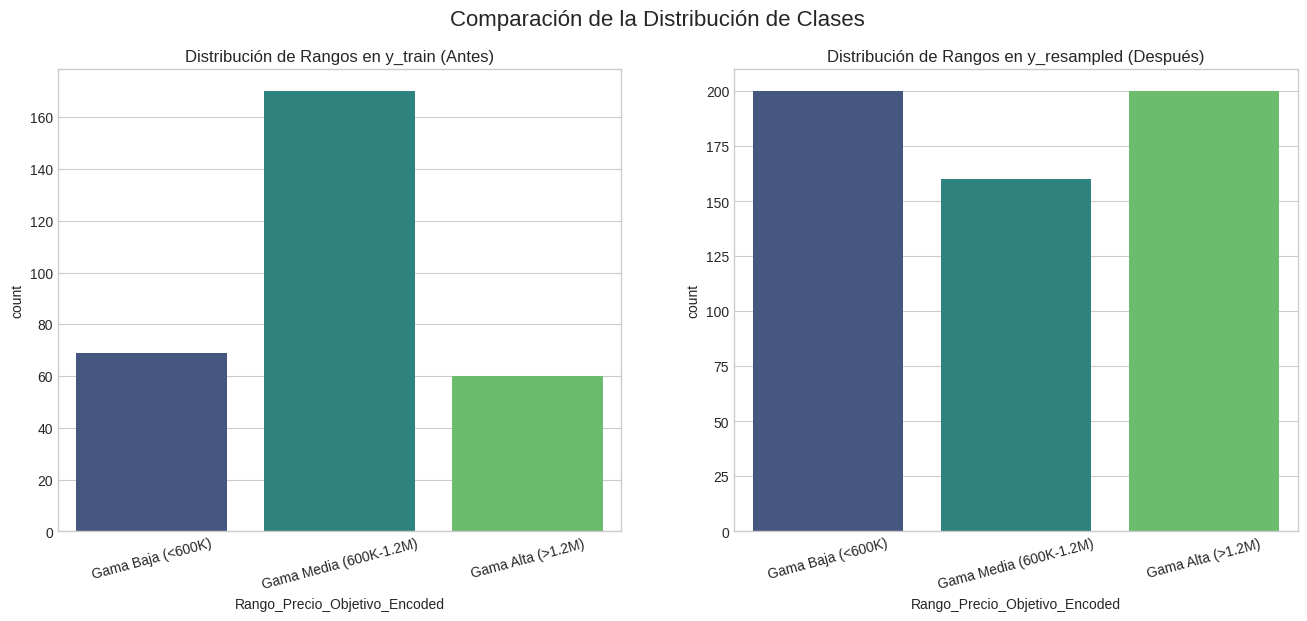

In [ ]:
# Celda de Balanceo Mejorada (Reemplaza las tuyas)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Import the standard Pipeline
from sklearn.model_selection import train_test_split # Import train_test_split

# --- PASO 1: Dividir los datos ANTES de cualquier balanceo ---
# Esto es CRUCIAL para evitar fuga de datos.
# Usaremos las variables X e y que definiste en la celda 4.4

# Split the data into training and testing sets
# Make sure X and y are defined from previous cells
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- PASO 2: Definir la estrategia de balanceo híbrida ---

# Get the encoded integer labels for the sampling strategies
# Make sure label_map and sorted_labels are available from previous cells
inverted_label_map = {v: k for k, v in label_map.items()}

# Corrected: Use the string labels directly as keys in the inverted_label_map
gama_baja_encoded_label = inverted_label_map[sorted_labels[0]]
gama_media_encoded_label = inverted_label_map[sorted_labels[1]]
gama_alta_encoded_label = inverted_label_map[sorted_labels[2]]

# Estrategia de Undersampling: Reducir la clase mayoritaria.
# Vamos a reducir la clase 'Gama Media' a 160 samples
undersample_strategy = {gama_media_encoded_label: 160}

# Estrategia de Oversampling (SMOTE):
# Aumentar las clases minoritarias. Las llevaremos a 200 samples.
oversample_strategy = {
    gama_baja_encoded_label: 200,
    gama_alta_encoded_label: 200
}

# Define the balancing pipeline
over = SMOTE(sampling_strategy=oversample_strategy, random_state=42)
under = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)


# --- Corrected Preprocessing: Impute before ColumnTransformer ---

# Impute missing values in numerical features with the median
imputer_numeric = SimpleImputer(strategy='median')
X_train[numeric_features] = imputer_numeric.fit_transform(X_train[numeric_features])
X_test[numeric_features] = imputer_numeric.transform(X_test[numeric_features])

# Impute missing values in categorical features with a constant 'missing'
# Separate boolean feature 'Es_Reacondicionado' as it might require different handling
categorical_features_str = [f for f in categorical_features if f != 'Es_Reacondicionado']
boolean_features = ['Es_Reacondicionado'] if 'Es_Reacondicionado' in categorical_features else []

if categorical_features_str:
    imputer_categorical_str = SimpleImputer(strategy='constant', fill_value='missing')
    X_train[categorical_features_str] = imputer_categorical_str.fit_transform(X_train[categorical_features_str])
    X_test[categorical_features_str] = imputer_categorical_str.transform(X_test[categorical_features_str])

if boolean_features:
    # Convert boolean to object or int before imputing
    X_train[boolean_features] = X_train[boolean_features].astype(object)
    X_test[boolean_features] = X_test[boolean_features].astype(object)

    imputer_boolean = SimpleImputer(strategy='most_frequent')
    X_train[boolean_features] = imputer_boolean.fit_transform(X_train[boolean_features])
    X_test[boolean_features] = imputer_boolean.transform(X_test[boolean_features])


# Check for remaining NaNs after imputation
print("\nNaNs remaining in X_train after imputation:")
print(X_train.isnull().sum().sum())
print("\nNaNs remaining in X_test after imputation:")
print(X_test.isnull().sum().sum())


# Define the ColumnTransformer with scaling for numeric and one-hot encoding for categorical
# Use the potentially modified lists of features after separating boolean
preprocessor_smote = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat_str', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_str),
        ('bool', OneHotEncoder(handle_unknown='ignore', sparse_output=False), boolean_features) # Handle boolean separately with OHE
    ],
    remainder='passthrough' # Keep other columns (shouldn't be any after dropping)
)

# Apply preprocessing to X_train before resampling
X_train_preprocessed = preprocessor_smote.fit_transform(X_train)

# Convert the preprocessed array back to a DataFrame for SMOTE
# Get feature names after one-hot encoding
feature_names = []
for name, transformer, features in preprocessor_smote.transformers_:
    if name in ['num', 'cat_str', 'bool']: # Check transformers by name
        ohe = transformer # For OneHotEncoder, transformer is the encoder itself
        # Handle potential None from get_feature_names_out for empty categories
        ohe_feature_names = ohe.get_feature_names_out(features)
        if ohe_feature_names is not None:
             feature_names.extend(ohe_feature_names)
        else:
             # Fallback if get_feature_names_out returns None (e.g., no data for a category)
             feature_names.extend([f'{f}_missing' for f in features]) # Placeholder names


X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, index=X_train.index, columns=feature_names)

# Define the balancing pipeline
balancing_pipeline = ImbPipeline(steps=[('o', over), ('u', under)])

# --- PASO 3: Aplicar el balanceo SOLO al conjunto de entrenamiento ---
# Use the preprocessed DataFrame and the encoded target values
X_resampled, y_resampled = balancing_pipeline.fit_resample(X_train_preprocessed_df, y_train)

# --- PASO 4: Analizar los resultados ---
print("\n--- Resultados del Balanceo Híbrido ---")
print(f"Dimensiones de X_train antes: {X_train_preprocessed_df.shape}")
print(f"Dimensiones de X_resampled después: {X_resampled.shape}")

print("\n--- Distribución de clases DESPUÉS del balanceo (en y_resampled) ---")
print(pd.Series(y_resampled).value_counts().sort_index())

# Visualizar la comparación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Use the label_map to get the string labels for plotting
y_train_labels = y_train.map(label_map)
y_resampled_labels = pd.Series(y_resampled).map(label_map)

sns.countplot(x=y_train_labels, ax=axes[0], palette="viridis", order=sorted_labels)
axes[0].set_title('Distribución de Rangos en y_train (Antes)')
axes[0].tick_params(axis='x', rotation=15)

sns.countplot(x=y_resampled_labels, ax=axes[1], palette="viridis", order=sorted_labels)
axes[1].set_title('Distribución de Rangos en y_resampled (Después)')
axes[1].tick_params(axis='x', rotation=15)


plt.suptitle('Comparación de la Distribución de Clases', fontsize=16)
plt.show()

##4.5 Preprocesamiento (Escalado y One-Hot Encoding)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

##4.6 Definir los Modelos de Machine Learning

In [ ]:
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42), # parametro max_iter
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

##4.7 Dividir los datos en conjuntos de entrenamiento y prueba

In [ ]:
import pandas as pd

print("\n--- Dividiendo datos en conjuntos de entrenamiento y prueba ---")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")
print("\nDistribución de clases en y_train:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nDistribución de clases en y_test:")
print(pd.Series(y_test).value_counts(normalize=True))


--- Dividiendo datos en conjuntos de entrenamiento y prueba ---
Dimensiones del conjunto de entrenamiento: (448, 38)
Dimensiones del conjunto de prueba: (112, 38)

Distribución de clases en y_train:
Rango_Precio_Objetivo_Encoded
0    0.357143
2    0.357143
1    0.285714
Name: proportion, dtype: float64

Distribución de clases en y_test:
Rango_Precio_Objetivo_Encoded
2    0.357143
0    0.357143
1    0.285714
Name: proportion, dtype: float64


##4.8 Entrenar modelos

In [ ]:
print("\n--- Evaluando cada modelo de clasificación ---")
X_columns = X.columns  # guardado antes del remuestreo
X_train = pd.DataFrame(X_train, columns=X_columns)
X_test = pd.DataFrame(X_test, columns=X_columns)

results = {}

for name, model in models.items():
    print(f"\nEvaluando: {name}")

    # Crear un pipeline para el modelo actual
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Inicializar la entrada en results para este modelo
    results[name] = {}

    try:
        print("Entrenando modelo...")
        pipeline.fit(X_train, y_train)

        results[name]['pipeline'] = pipeline

        print("Realizando predicciones en conjunto de prueba...")
        y_pred = pipeline.predict(X_test)
        results[name]['y_pred'] = y_pred # Store the predictions here

        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=sorted_labels)

        results[name]['accuracy'] = accuracy
        results[name]['report'] = report

        print(f"Precisión (Accuracy) en conjunto de prueba: {accuracy:.4f}")

        # Cross-validation
        print("Realizando Cross-Validation (10 folds)...")
        cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
        print(f"Puntuaciones de Cross-Validation: {cv_scores}")
        print(f"Precisión promedio de Cross-Validation: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        results[name]['cv_mean_accuracy'] = cv_scores.mean()
        results[name]['cv_std_accuracy'] = cv_scores.std()

    except Exception as e:
        print(f"Error al entrenar o evaluar el modelo {name}: {e}")
        results[name]['error'] = str(e)


--- Evaluando cada modelo de clasificación ---

Evaluando: Regresión Logística
Entrenando modelo...
Realizando predicciones en conjunto de prueba...
Precisión (Accuracy) en conjunto de prueba: 0.5625
Realizando Cross-Validation (10 folds)...
Puntuaciones de Cross-Validation: [0.78947368 0.68421053 0.68421053 0.76315789 0.75675676 0.89189189
 0.67567568 0.67567568 0.64864865 0.7027027 ]
Precisión promedio de Cross-Validation: 0.7272 (+/- 0.0700)

Evaluando: KNN
Entrenando modelo...
Realizando predicciones en conjunto de prueba...
Precisión (Accuracy) en conjunto de prueba: 0.5446
Realizando Cross-Validation (10 folds)...
Puntuaciones de Cross-Validation: [0.68421053 0.60526316 0.65789474 0.73684211 0.7027027  0.7027027
 0.43243243 0.7027027  0.56756757 0.64864865]
Precisión promedio de Cross-Validation: 0.6441 (+/- 0.0854)

Evaluando: SVC
Entrenando modelo...
Realizando predicciones en conjunto de prueba...
Precisión (Accuracy) en conjunto de prueba: 0.5714
Realizando Cross-Validation 

##4.9 Comparar Resultados y Seleccionar el Mejor Modelo

In [ ]:
print("\n--- Resumen de Resultados de los Modelos ---")
best_model_name = None
best_accuracy = -1

for name, result in results.items():
    if 'error' in result:
        print(f"Modelo: {name} - Error: {result['error']}")
    else:
        print(f"\nModelo: {name}")
        print(f"\n  Precisión en Prueba: {result['accuracy']:.4f}")
        if 'cv_mean_accuracy' in result:
            print(f"  Precisión Promedio (10 folds): {result['cv_mean_accuracy']:.4f} (+/- {result['cv_std_accuracy']:.4f})")
            if result['cv_mean_accuracy'] > best_accuracy:
                 best_accuracy = result['cv_mean_accuracy']
                 best_model_name = name
        else:
             if result['accuracy'] > best_accuracy:
                 best_accuracy = result['accuracy']
                 best_model_name = name

print(f"\n--- Selección del Mejor Modelo ---")
if best_model_name:
    print(f"El modelo con mejor rendimiento aparente es: {best_model_name}")
    print("Métricas detalladas del mejor modelo:")
    print(f"  Precisión en Prueba: {results[best_model_name]['accuracy']:.4f}")
    print("  Reporte de Clasificación:")
    print(results[best_model_name]['report'])
    if 'cv_mean_accuracy' in results[best_model_name]:
        print(f"  Precisión Promedio (10 folds): {results[best_model_name]['cv_mean_accuracy']:.4f} (+/- {results[best_model_name]['cv_std_accuracy']:.4f})")
else:
    print("No se pudo determinar el mejor modelo debido a errores de entrenamiento.")


--- Resumen de Resultados de los Modelos ---

Modelo: Regresión Logística

  Precisión en Prueba: 0.5625
  Precisión Promedio (10 folds): 0.7272 (+/- 0.0700)

Modelo: KNN

  Precisión en Prueba: 0.5446
  Precisión Promedio (10 folds): 0.6441 (+/- 0.0854)

Modelo: SVC

  Precisión en Prueba: 0.5714
  Precisión Promedio (10 folds): 0.6762 (+/- 0.0620)

Modelo: Random Forest

  Precisión en Prueba: 0.6250
  Precisión Promedio (10 folds): 0.7006 (+/- 0.0643)

Modelo: Gradient Boosting

  Precisión en Prueba: 0.6429
  Precisión Promedio (10 folds): 0.7058 (+/- 0.0710)

--- Selección del Mejor Modelo ---
El modelo con mejor rendimiento aparente es: Regresión Logística
Métricas detalladas del mejor modelo:
  Precisión en Prueba: 0.5625
  Reporte de Clasificación:
                        precision    recall  f1-score   support

     Gama Baja (<600K)       0.74      0.57      0.65        40
Gama Media (600K-1.2M)       0.37      0.53      0.44        32
     Gama Alta (>1.2M)       0.66      

##4.10 Ejemplo de Predicción con el Mejor Modelo Seleccionado

In [ ]:
if best_model_name and 'error' not in results[best_model_name]:
    print(f"\n--- Usando el modelo {best_model_name} para predecir un nuevo producto ---")

    best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', models[best_model_name])])
    # Retrain the pipeline using the original X and y data before resampling
    # This ensures the preprocessor is fitted correctly on the full dataset
    best_pipeline.fit(X, y)

    # Define datos de un nuevo producto como ejemplo
    new_product_data = pd.DataFrame({
        'RAM_GB': [8.0],
        'Capacidad_Almacenamiento_GB': [512.0],
        'Pantalla_Pulgadas': [14.0],
        'Marca_Grupo': ['LENOVO'],
        # Include the new processor features
        'Procesador_Marca': ['Intel'], # Assuming an Intel processor for this example
        'Procesador_Serie': ['Core i3'], # Assuming a Core i5 series for this example
        'Tarjeta_Grafica_Grupo': ['Integrada/No Dedicada'],
        'Tipo_Almacenamiento': ['SSD'],
        'Es_Reacondicionado': [False]
    })

    # Ensure the new product data has the same columns as the training data X
    new_product_data = new_product_data[X.columns]

    # Hacer la predicción
    new_prediction_encoded = best_pipeline.predict(new_product_data)

    # Mapear la predicción de vuelta a la etiqueta original
    # Make sure label_map is accessible. If it's not global, you might need to recreate it or pass it.
    # Assuming label_map is available from previous cells.
    predicted_label = label_map.get(new_prediction_encoded[0], 'Desconocido')


    print(f"Características del nuevo producto: {new_product_data.iloc[0].to_dict()}")
    print(f"Predicción (Encoded): {new_prediction_encoded[0]}")
    print(f"Predicción (Etiqueta): {predicted_label}")


--- Usando el modelo Regresión Logística para predecir un nuevo producto ---
Características del nuevo producto: {'RAM_GB': 8.0, 'Capacidad_Almacenamiento_GB': 512.0, 'Pantalla_Pulgadas': 14.0, 'Marca_Grupo': 'LENOVO', 'Procesador_Marca': 'Intel', 'Procesador_Serie': 'Core i3', 'Tarjeta_Grafica_Grupo': 'Integrada/No Dedicada', 'Tipo_Almacenamiento': 'SSD', 'Es_Reacondicionado': False}
Predicción (Encoded): 1
Predicción (Etiqueta): Gama Media (600K-1.2M)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Asegurarse de importar numpy

print("\n--- Generando Matriz de Confusión para Regresión Logística ---")

logistic_model_key = "Regresión Logística"

# Asegurarse de que el modelo y su pipeline existan en los resultados
if logistic_model_key in results and 'pipeline' in results[logistic_model_key]:
    logistic_pipeline = results[logistic_model_key]['pipeline']

    print("\nReporte de Clasificación para Regresión Logística:")
    # Imprimir el reporte de clasificación que ya se calculó antes
    # Esto es útil para ver métricas como precisión, recall, f1-score por clase
    print(results[logistic_model_key]['report'])

    try:
        # Hacer la predicción en el conjunto de prueba
        y_pred_logistic = logistic_pipeline.predict(X_test)

        # --- Paso de conversión explícita a numpy array con tipo entero ---
        # Esto es para asegurar que los inputs de confusion_matrix sean del tipo correcto
        y_test_np = np.asarray(y_test, dtype=np.int64)
        y_pred_logistic_np = np.asarray(y_pred_logistic, dtype=np.int64)
        # ----------------------------------------------------------------

        # Calcular la matriz de confusión usando los arrays convertidos
        cm_logistic = confusion_matrix(y_test_np, y_pred_logistic_np)

        # Graficar matriz de confusión usando el mapa de calor de Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted_labels, # Usar las etiquetas originales para los ejes
                    yticklabels=sorted_labels)
        plt.title('Matriz de Confusión - Regresión Logística')
        plt.xlabel('Clase Predicha')
        plt.ylabel('Clase Verdadera')
        plt.xticks(rotation=45, ha='right') # Mejorar legibilidad de etiquetas
        plt.yticks(rotation=0)
        plt.tight_layout() # Ajustar layout para que no se corten las etiquetas
        plt.show()

    except Exception as e:
        print(f"Error al generar la matriz de confusión para Regresión Logística: {e}")

elif logistic_model_key in results and 'error' in results[logistic_model_key]:
    print(f"No se pudo generar la matriz de confusión para Regresión Logística porque falló el entrenamiento: {results[logistic_model_key]['error']}")
else:
    print(f"El modelo '{logistic_model_key}' no se encontró en los resultados o no se almacenó el pipeline.")


--- Generando Matriz de Confusión para Regresión Logística ---

Reporte de Clasificación para Regresión Logística:
                        precision    recall  f1-score   support

     Gama Baja (<600K)       0.74      0.57      0.65        40
Gama Media (600K-1.2M)       0.37      0.53      0.44        32
     Gama Alta (>1.2M)       0.66      0.57      0.61        40

              accuracy                           0.56       112
             macro avg       0.59      0.56      0.57       112
          weighted avg       0.61      0.56      0.57       112

Error al generar la matriz de confusión para Regresión Logística: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


##4.11 Matriz de Confusion para KNN

In [ ]:
print("\n--- Generando Matriz de Confusión para KNN ---")
knn_pipeline_key = "KNN"

if knn_pipeline_key in results and 'pipeline' in results[knn_pipeline_key]:
    knn_pipeline = results[knn_pipeline_key]['pipeline']

    print("\nReporte de Clasificación para KNN:")
    print(results[knn_pipeline_key]['report'])

    try:
        y_pred_knn = knn_pipeline.predict(X_test)

        # Calcular la matriz de confusión
        cm_knn = confusion_matrix(y_test, y_pred_knn)

        # Graficar matriz de confusión usando el mapa de calor de Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted_labels, yticklabels=sorted_labels)
        plt.title('Matriz de Confusión - KNN')
        plt.xlabel('Clase Predicha')
        plt.ylabel('Clase Verdadera')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al generar la matriz de confusión para KNN: {e}")

elif knn_pipeline_key in results and 'error' in results[knn_pipeline_key]:
    print(f"No se pudo generar la matriz de confusión para KNN porque falló el entrenamiento: {results[knn_pipeline_key]['error']}")
else:
    print(f"El modelo '{knn_pipeline_key}' no se encontró en los resultados o no se almacenó el pipeline.")


--- Generando Matriz de Confusión para KNN ---

Reporte de Clasificación para KNN:
                        precision    recall  f1-score   support

     Gama Baja (<600K)       0.75      0.68      0.71        40
Gama Media (600K-1.2M)       0.38      0.75      0.51        32
     Gama Alta (>1.2M)       0.77      0.25      0.38        40

              accuracy                           0.54       112
             macro avg       0.63      0.56      0.53       112
          weighted avg       0.65      0.54      0.53       112

Error al generar la matriz de confusión para KNN: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


##4.12 Matriz de Confusion para Gradient Boosting


--- Generando Matriz de Confusión para el Mejor Modelo: Gradient Boosting ---

Reporte de Clasificación para Gradient Boosting:
                        precision    recall  f1-score   support

     Gama Baja (<600K)       0.72      0.70      0.71        40
Gama Media (600K-1.2M)       0.49      0.66      0.56        32
     Gama Alta (>1.2M)       0.77      0.57      0.66        40

              accuracy                           0.64       112
             macro avg       0.66      0.64      0.64       112
          weighted avg       0.67      0.64      0.65       112



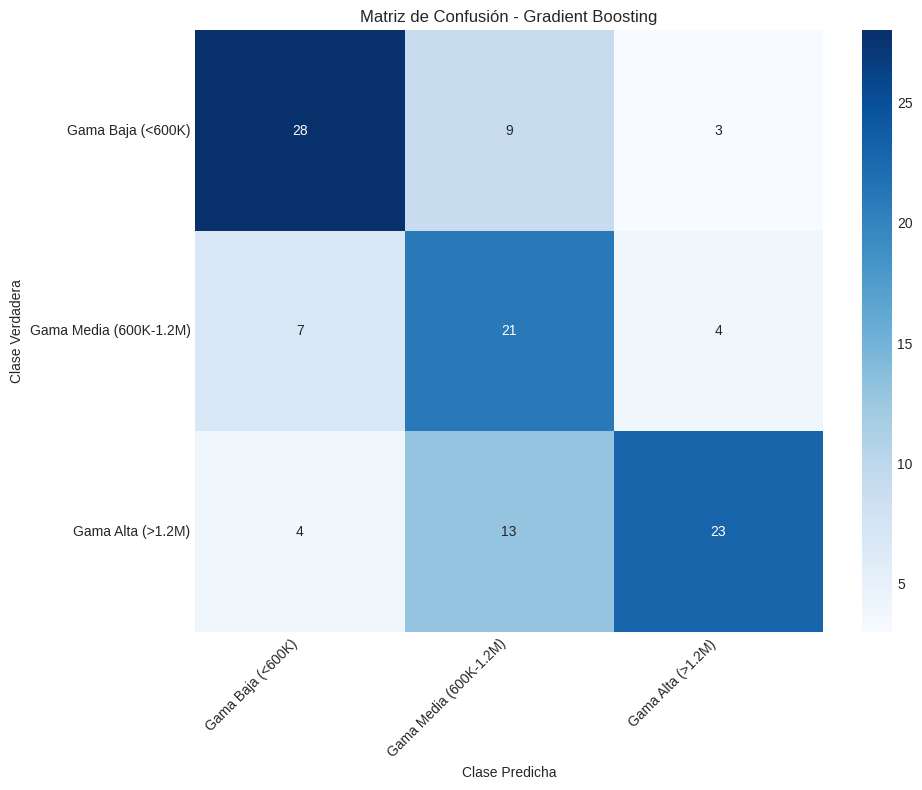

In [ ]:
# Celda 4.11: Matriz de Confusión para Gradient Boosting (CORREGIDA)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np # Asegúrate de importar numpy

print("\n--- Generando Matriz de Confusión para el Mejor Modelo: Gradient Boosting ---")

best_model_key = "Gradient Boosting"

if best_model_key in results and 'pipeline' in results[best_model_key] and 'y_pred' in results[best_model_key]:
    best_pipeline = results[best_model_key]['pipeline']

    print("\nReporte de Clasificación para Gradient Boosting:")
    print(results[best_model_key]['report'])

    try:
        # Ya tenemos las predicciones, no hace falta volver a predecir
        y_pred_best = results[best_model_key]['y_pred']

        # ---> SOLUCIÓN: Asegurar que y_test y y_pred sean arrays numéricos <---
        # Convertimos y_test (que puede ser una Serie de pandas con dtype 'object') a un array de numpy
        y_test_numeric = np.array(y_test).astype(int)
        # Hacemos lo mismo para las predicciones por seguridad
        y_pred_numeric = np.array(y_pred_best).astype(int)

        # Calcular la matriz de confusión con los arrays numéricos limpios
        cm = confusion_matrix(y_test_numeric, y_pred_numeric)

        # Graficar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted_labels, yticklabels=sorted_labels)
        plt.title('Matriz de Confusión - Gradient Boosting')
        plt.xlabel('Clase Predicha')
        plt.ylabel('Clase Verdadera')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error al generar la matriz de confusión para {best_model_key}: {e}")

elif best_model_key in results and 'error' in results[best_model_key]:
    print(f"No se pudo generar la matriz de confusión para Gradient Boosting porque falló el entrenamiento: {results[best_model_key]['error']}")
else:
    print(f"El modelo '{best_model_key}' no se encontró en los resultados.")

## 4.12 Matriz de Confusion para Regresión Logística

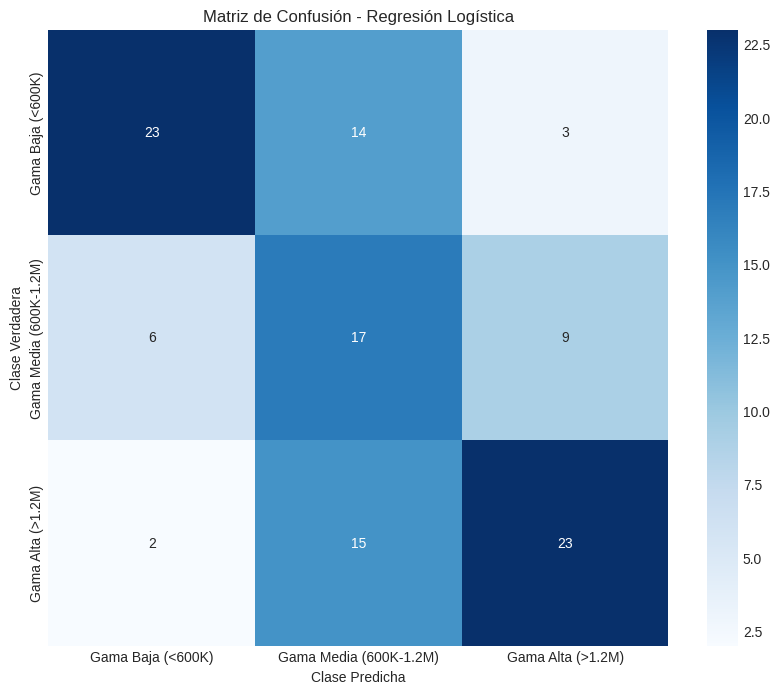

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clave del modelo que quieres visualizar
# Use the best model determined in the previous step
model_key = best_model_name

# Obtener las predicciones que guardaste para este modelo
# Corrected: Get the predictions from the results dictionary
if model_key in results and 'y_pred' in results[model_key]:
    y_pred_model = results[model_key]['y_pred']
else:
    # If predictions weren't stored, make them now using the pipeline
    if model_key in results and 'pipeline' in results[model_key]:
        model_pipeline = results[model_key]['pipeline']
        y_pred_model = model_pipeline.predict(X_test)
        # Optionally store the predictions for later use
        results[model_key]['y_pred'] = y_pred_model
    else:
        print(f"Error: Could not find predictions or pipeline for model '{model_key}'.")
        # Exit or handle the error as needed
        exit() # Stop execution if predictions cannot be obtained

# Las etiquetas verdaderas son siempre las mismas
y_true = y_test

# Asegurar que ambos son arrays numéricos para evitar errores
y_true_numeric = np.array(y_true).astype(int)
y_pred_numeric = np.array(y_pred_model).astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_true_numeric, y_pred_numeric)

# Visualizarla
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.title(f'Matriz de Confusión - {model_key}')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

# <center><h1><b>5. VISUALIZACION E INTERPRETACION</b></h1></center>


##5.1 Importancia de las Características


In [ ]:
print("\n--- 5.1 Importancia de las Características (Feature Importance) ---")

# Extraer el preprocesador y el clasificador del pipeline
best_pipeline = results[best_model_name]['pipeline']
preprocessor_fitted = best_pipeline.named_steps['preprocessor']
classifier_fitted = best_pipeline.named_steps['classifier']

# Check if the best model supports feature_importances_
if hasattr(classifier_fitted, 'feature_importances_'):
    # Obtener los nombres de las características después del One-Hot Encoding
    # Need to fit the preprocessor first to get the feature names
    X_train_processed = preprocessor_fitted.fit_transform(X_train) # Use X_train here as it was used for fitting the pipeline

    # Get feature names from the preprocessor
    feature_names = []
    for name, transformer, features in preprocessor_fitted.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
            # Access the fitted OneHotEncoder within the pipeline step
            ohe = transformer.named_steps['onehot']
            # Handle potential None from get_feature_names_out for empty categories
            ohe_feature_names = ohe.get_feature_names_out(features)
            if ohe_feature_names is not None:
                 feature_names.extend(ohe_feature_names)
            else:
                 # Fallback if get_feature_names_out returns None (e.g., no data for a category)
                 # This might indicate an issue earlier or sparse categories.
                 # For now, use placeholder names.
                 feature_names.extend([f'{f}_missing' for f in features]) # Placeholder names

    # Obtener las importancias
    importances = classifier_fitted.feature_importances_

    # Crear un DataFrame para facilitar la visualización
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Graficar las características más importantes
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
    plt.title(f'Top 15 Características Más Importantes - {best_model_name}')
    plt.xlabel('Importancia')
    plt.ylabel('Característica')
    plt.show()
else:
    print(f"El modelo seleccionado ('{best_model_name}') no soporta la extracción directa de la importancia de las características.")
    print("La importancia de las características se puede obtener directamente de modelos basados en árboles como Random Forest o Gradient Boosting.")


--- 5.1 Importancia de las Características (Feature Importance) ---
El modelo seleccionado ('Regresión Logística') no soporta la extracción directa de la importancia de las características.
La importancia de las características se puede obtener directamente de modelos basados en árboles como Random Forest o Gradient Boosting.


DataFrame listo para el modelo cargado correctamente.

Entrenando el pipeline de Regresión Logística...
Entrenamiento completado.

--- Visualizando la Influencia de las Características por Rango de Precio ---


/tmp/ipython-input-321-2520241550.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette="vlag")


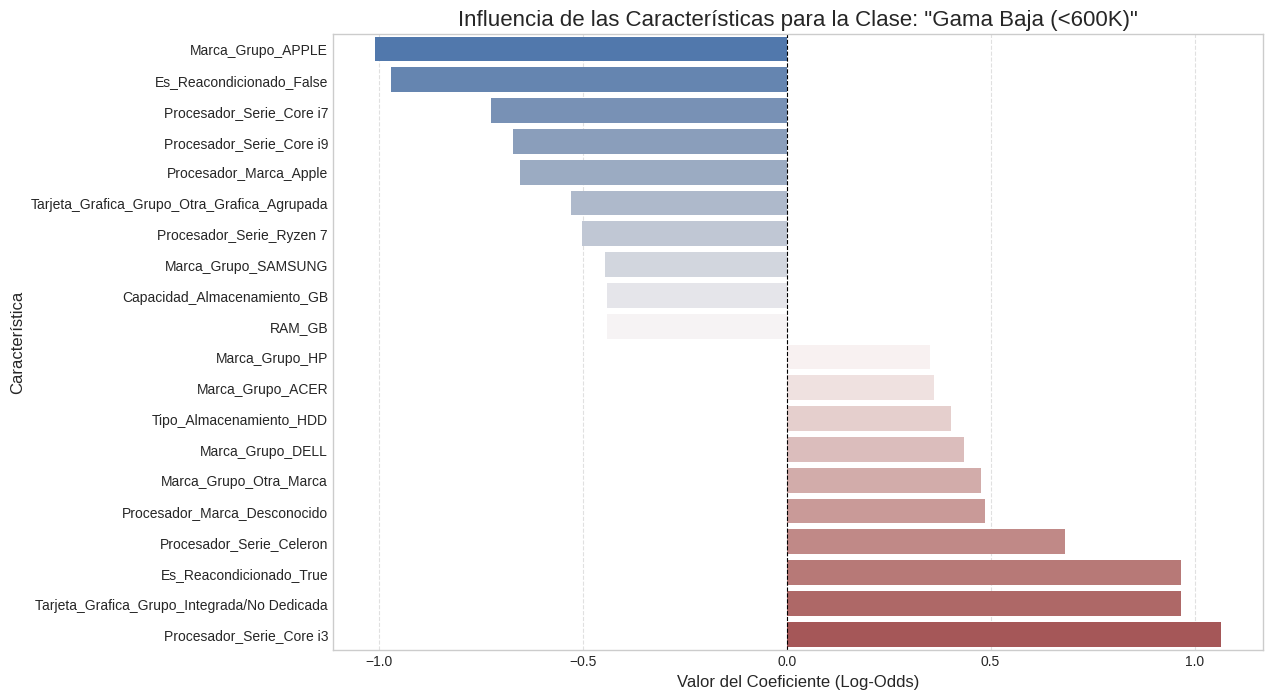

/tmp/ipython-input-321-2520241550.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette="vlag")


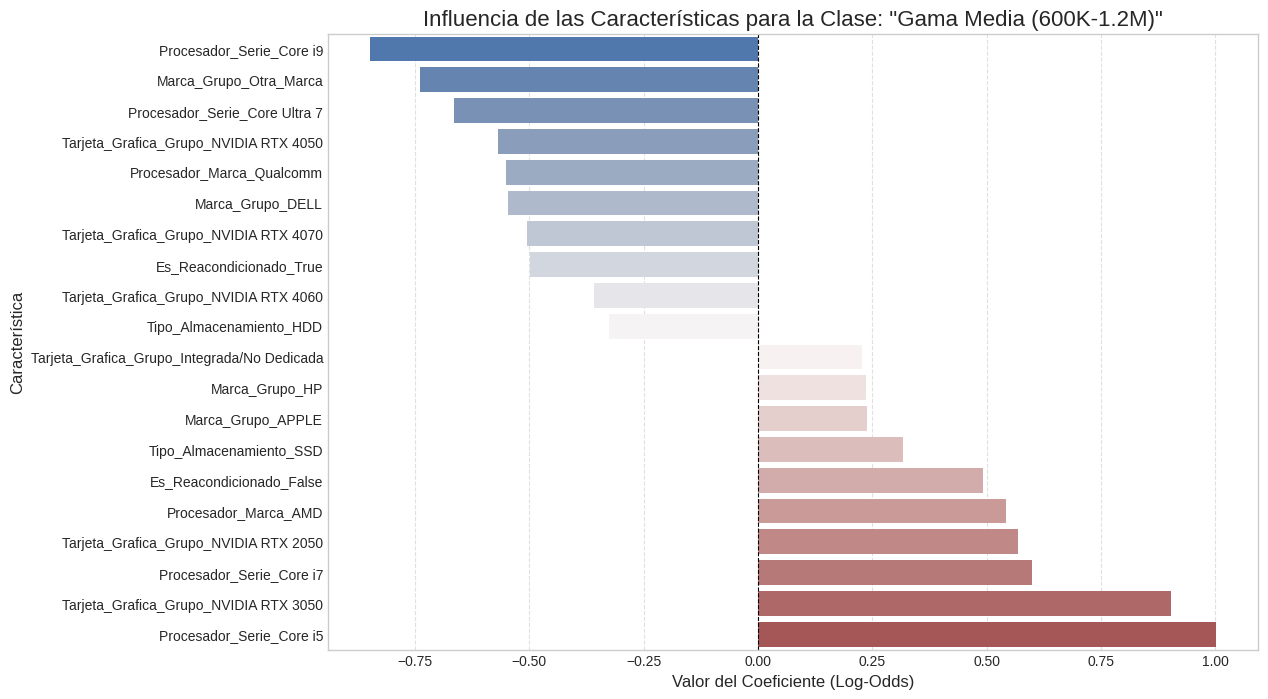

/tmp/ipython-input-321-2520241550.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_coefs.values, y=top_coefs.index, palette="vlag")


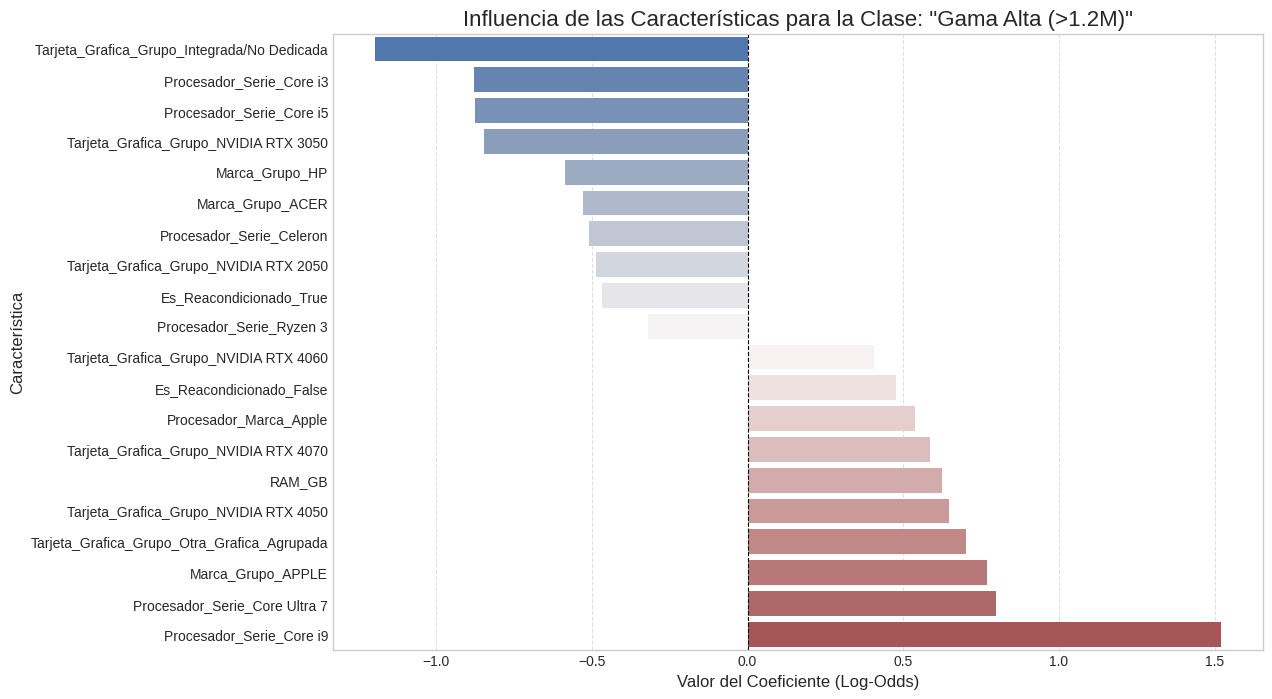

In [ ]:
# --- 5.2 INTERPRETACIÓN DE COEFICIENTES PARA REGRESIÓN LOGÍSTICA ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# --- PASO 1: CARGAR DATOS Y RECREAR EL ENTORNO DEL MODELO ---

# Cargar el dataset final listo para el modelado
try:
    df_model = pd.read_csv('productos_falabella_listo_para_modelo_vFINAL_ordenado.csv')
    print("DataFrame listo para el modelo cargado correctamente.")
except FileNotFoundError:
    print("Error: Archivo 'productos_falabella_listo_para_modelo_vFINAL_ordenado.csv' no encontrado.")
    exit()

# Definir características y objetivo (debe coincidir con la celda de modelado)
features_cols = ['RAM_GB', 'Capacidad_Almacenamiento_GB', 'Pantalla_Pulgadas',
                 'Marca_Grupo', 'Procesador_Marca', 'Procesador_Serie',
                 'Tarjeta_Grafica_Grupo', 'Tipo_Almacenamiento', 'Es_Reacondicionado']
target_col = 'Rango_Precio_Objetivo_Encoded'
X = df_model[features_cols]
y = df_model[target_col]

# Recrear el mapeo de etiquetas para los gráficos
label_map = {
    0: 'Gama Baja (<600K)',
    1: 'Gama Media (600K-1.2M)',
    2: 'Gama Alta (>1.2M)'
}
class_names = [label_map[key] for key in sorted(label_map.keys())]

# --- PASO 2: ENTRENAR EL PIPELINE DE REGRESIÓN LOGÍSTICA ---

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Definir el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Crear y entrenar el pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

print("\nEntrenando el pipeline de Regresión Logística...")
logistic_pipeline.fit(X, y)
print("Entrenamiento completado.")

# --- PASO 3: EXTRAER COEFICIENTES Y NOMBRES DE CARACTERÍSTICAS ---

# Extraer el clasificador y el preprocesador entrenados
classifier = logistic_pipeline.named_steps['classifier']
preprocessor_fitted = logistic_pipeline.named_steps['preprocessor']

# Extraer los nombres de las características después del One-Hot Encoding
ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(ohe_feature_names)

# Crear un DataFrame con los coeficientes para una fácil interpretación
# El modelo multiclase 'ovr' (one-vs-rest) genera un conjunto de coeficientes para cada clase
coef_df = pd.DataFrame(classifier.coef_, columns=feature_names, index=class_names).T

# --- PASO 4: VISUALIZAR LOS COEFICIENTES ---

print("\n--- Visualizando la Influencia de las Características por Rango de Precio ---")

# Graficar los coeficientes para cada clase
for i, class_name in enumerate(class_names):
    # Seleccionar y ordenar los coeficientes para la clase actual
    class_coefs = coef_df[class_name].sort_values(ascending=False)

    # Tomar las 10 características con mayor influencia positiva y 10 con mayor negativa
    top_coefs = pd.concat([class_coefs.head(10), class_coefs.tail(10)]).sort_values()

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_coefs.values, y=top_coefs.index, palette="vlag")
    plt.title(f'Influencia de las Características para la Clase: "{class_name}"', fontsize=16)
    plt.xlabel('Valor del Coeficiente (Log-Odds)', fontsize=12)
    plt.ylabel('Característica', fontsize=12)
    plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

##5.2 Importancia de las Características (Coef y Odds Ratio)

In [ ]:
from sklearn.compose import ColumnTransformer
import warnings

# Suprimir posibles advertencias futuras de pandas al manipular DataFrames
warnings.filterwarnings('ignore', category=FutureWarning)

print("\n--- Extrayendo Coeficientes y Odds Ratios del Modelo de Regresión Logística ---")

# Asegurarse de tener las variables necesarias de celdas anteriores
# X, y, results, best_model_name, sorted_labels

logistic_model_key = "Regresión Logística"

if logistic_model_key in results and 'pipeline' in results[logistic_model_key]:
    best_pipeline = results[logistic_model_key]['pipeline']

    # Acceder al preprocesador y clasificador ajustados dentro del pipeline
    preprocessor_fitted = best_pipeline.named_steps['preprocessor']
    classifier_fitted = best_pipeline.named_steps['classifier']

    # Verificar si el clasificador es un modelo de Regresión Logística y tiene coeficientes
    if hasattr(classifier_fitted, 'coef_'):

        # Obtener los nombres de las características después del preprocesamiento (escalado y One-Hot Encoding)
        # Usamos el método get_feature_names_out del preprocesador ajustado
        try:
             feature_names_out = preprocessor_fitted.get_feature_names_out(X.columns)
        except Exception as e:
             print(f"Error al obtener los nombres de las características del preprocesador: {e}")
             print("No se puede generar la tabla de coeficientes detallada.")
             feature_names_out = None # Indicar que no pudimos obtener los nombres


        if feature_names_out is not None:
            # Extraer los coeficientes (coef_) del modelo de Regresión Logística ajustado
            # Para clasificación multiclase (OvR o multinomial), coef_ es un array 2D con forma (n_clases, n_características_out)
            # Cada fila corresponde a una clase, en el orden de tus etiquetas codificadas (0, 1, 2)
            coefficients = classifier_fitted.coef_

            # Calcular los Odds Ratios (OR = exp(coef))
            odds_ratios = np.exp(coefficients)

            # Crear un DataFrame para mostrar los resultados de manera organizada
            # Cada fila es una característica (transformada), las columnas son coeficientes y ORs para cada clase

            # Crear una lista de nombres de columnas para el DataFrame
            # Asegurar que sorted_labels existe y corresponde a las clases codificadas 0, 1, 2
            # Asumimos que sorted_labels está ordenado [etiqueta_0, etiqueta_1, etiqueta_2]
            df_columns = ['Característica']
            for i, label in enumerate(sorted_labels):
                 df_columns.append(f'Coef_{label}')
                 df_columns.append(f'OR_{label}')

            # Crear los datos para el DataFrame
            df_data = []
            for i, feature_name in enumerate(feature_names_out):
                row_data = [feature_name]
                for class_index in range(coefficients.shape[0]): # Iterar a través de los coeficientes de cada clase
                    row_data.append(coefficients[class_index, i])
                    row_data.append(odds_ratios[class_index, i])
                df_data.append(row_data)

            coef_or_df = pd.DataFrame(df_data, columns=df_columns)

            # Opcional: Ordenar por el valor absoluto de la suma de los coeficientes
            # para ver las características más influyentes en general.
            coef_or_df['Suma_Abs_Coef'] = np.sum(np.abs(coefficients), axis=0)
            coef_or_df = coef_or_df.sort_values(by='Suma_Abs_Coef', ascending=False).drop(columns=['Suma_Abs_Coef'])


            # Mostrar el DataFrame
            print("\n--- Tabla de Coeficientes y Odds Ratios (Características principales) ---")
            # Mostrar top N características, por ejemplo, 20
            print(coef_or_df.head(20).to_string(index=False)) # to_string(index=False) para no mostrar el índice de pandas

            print("\n--- Notas de Interpretación ---")
            print("Esta tabla muestra cómo cada característica *después del preprocesamiento* influye en la predicción.")
            print("Para características numéricas (como RAM_GB_num):")
            print("  - Un Coef > 0 (OR > 1) para una clase significa que un valor más alto de esa característica (relativo a la media/escala) AUMENTA las odds de que sea de esa clase (frente a otras).")
            print("  - Un Coef < 0 (OR < 1) para una clase significa que un valor más alto DISMINUYE las odds de que sea de esa clase.")
            print("Para características categóricas (como Marca_Grupo_LENOVO_cat_str):")
            print("  - El Coef/OR se interpreta cuando esta categoría específica está presente (valor 1 en la one-hot encoding) frente a la categoría de referencia (que no tiene una columna propia) y todas las demás categorías (que tienen valor 0 en esta columna).")
            print("  - Un Coef > 0 (OR > 1) para una clase indica que pertenecer a esta categoría AUMENTA las odds de que sea de esa clase.")
            print("  - Un Coef < 0 (OR < 1) para una clase indica que pertenecer a esta categoría DISMINUYE las odds de que sea de esa clase.")
            print("\nRecuerda que la interpretación exacta de Coeficientes y ORs en modelos multiclase con regularización (como la Regresión Logística por defecto en scikit-learn) puede ser compleja y a menudo se usa más para entender la dirección e intensidad *relativa* de las influencias de las características.")

        else:
            print("\nNo se pudo obtener la lista de nombres de características procesadas. La tabla no puede ser generada.")


    else:
        print(f"El clasificador '{type(classifier_fitted).__name__}' no tiene un atributo 'coef_'.")
        print("Este método funciona mejor para modelos lineales como Regresión Logística.")

elif logistic_model_key in results and 'error' in results[logistic_model_key]:
    print(f"\nError: El entrenamiento del modelo '{logistic_model_key}' falló. No se pueden extraer los coeficientes.")
    print(f"Detalles del error: {results[logistic_model_key]['error']}")

else:
    print(f"\nError: El modelo '{logistic_model_key}' o su pipeline no se encontraron en el diccionario 'results'.")
    print("Asegúrate de haber ejecutado las celdas de entrenamiento del modelo correctamente y que 'best_model_name' sea correcto.")


--- Extrayendo Coeficientes y Odds Ratios del Modelo de Regresión Logística ---

--- Tabla de Coeficientes y Odds Ratios (Características principales) ---
                                  Característica  Coef_Gama Baja (<600K)  OR_Gama Baja (<600K)  Coef_Gama Media (600K-1.2M)  OR_Gama Media (600K-1.2M)  Coef_Gama Alta (>1.2M)  OR_Gama Alta (>1.2M)
                   cat__Procesador_Serie_Core i9               -0.671180              0.511105                    -0.847923                   0.428304                1.519103              4.568123
cat__Tarjeta_Grafica_Grupo_Integrada/No Dedicada                0.967017              2.630086                     0.228370                   1.256550               -1.195386              0.302587
                   cat__Procesador_Serie_Core i3                1.063997              2.897931                    -0.185904                   0.830353               -0.878093              0.415575
                          cat__Marca_Grupo_APPLE        

# **Descarga modelo final .pkl**

> Agregar bloque entrecomillado



In [ ]:
import pickle

with open("modelo_final.pkl", "wb") as f:
    pickle.dump(best_pipeline, f) # Changed rf_pipeline to best_pipeline

In [ ]:
from google.colab import files

files.download("modelo_final.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>